In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

### 解析数据

In [2]:
data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

In [3]:
train_x = data.drop(['label'], axis=1)
train_y = data['label']

In [4]:
train_y_5 = (train_y == 5)
train_y_5.shape

(42000,)

### 可视化

In [11]:
fig_datas = data.drop('label', 1) / 255
label_datas = data['label']

test_fig_datas = test_data / 255

In [12]:
# transform a n*n size series to a n*n data frame 
def transformDataFrameFromSeries(data):
#     df = pd.DataFrame()
    size = int(math.sqrt(data.size))
#     for i in range(size):
#         df = df.append(data.iloc[i * size : (i * size + size)].reset_index(drop=True),ignore_index=True)
    return pd.DataFrame(data.reshape((size, size)))

/home/cyl/project/virtualenv/tensorflow/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  import sys


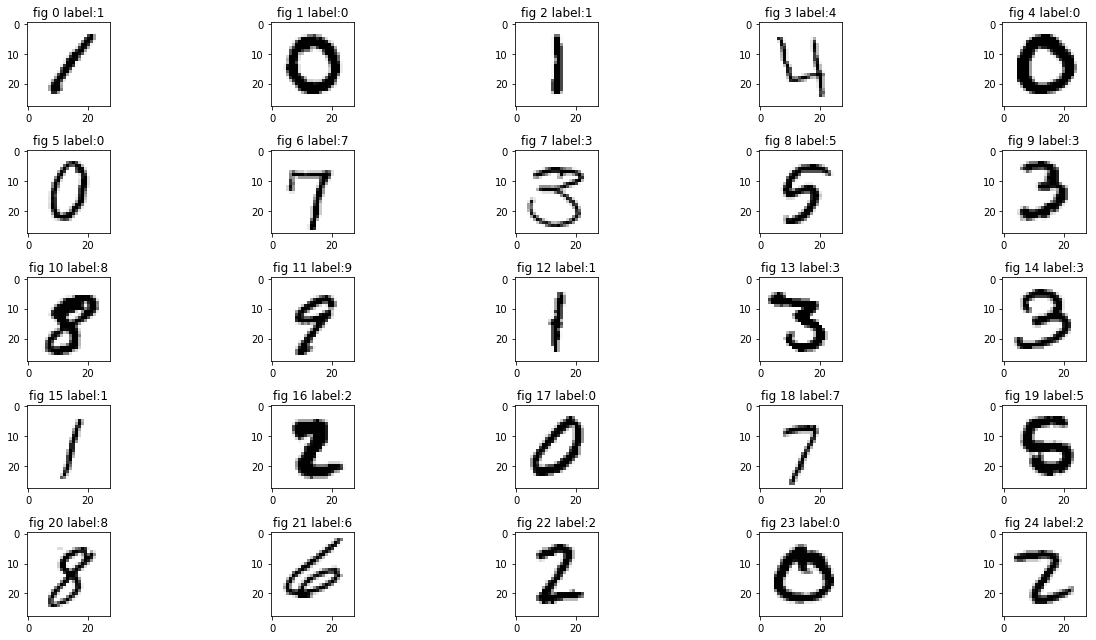

In [19]:
# show some fig
plt.figure(figsize=(18,9))
for i in range(25):
    ax = plt.subplot2grid((5,5),(i / 5, i % 5))
    fig_data = fig_datas.iloc[i]
    ax.imshow(transformDataFrameFromSeries(fig_data), cmap=plt.cm.gray_r)
    plt.title('fig %s label:%s' % (i, label_datas[i]))
plt.tight_layout()
plt.show()

/home/cyl/project/virtualenv/tensorflow/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  import sys
/home/cyl/project/virtualenv/tensorflow/tensorflow/lib/python2.7/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


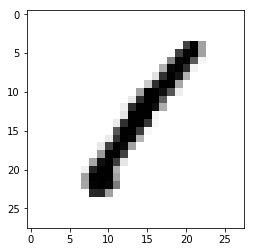

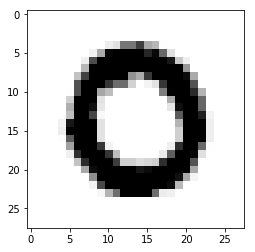

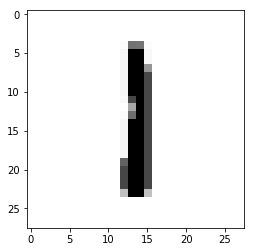

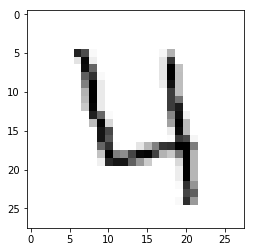

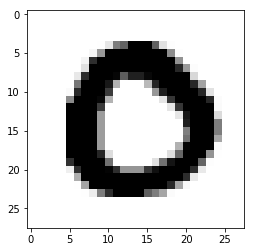

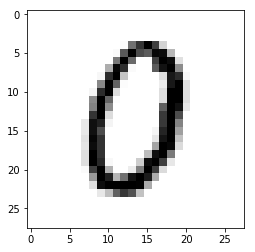

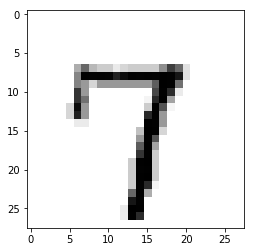

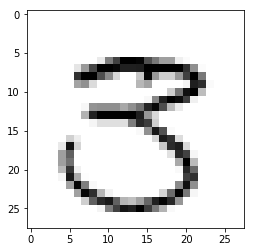

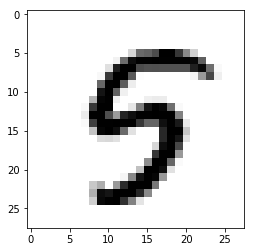

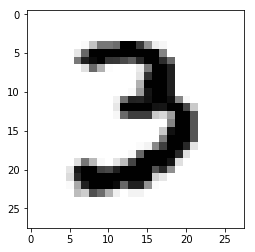

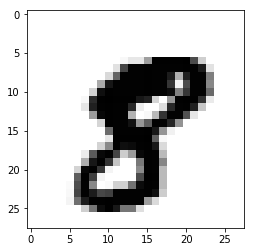

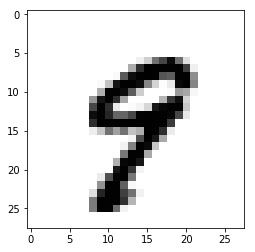

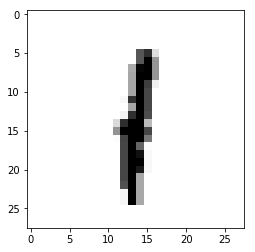

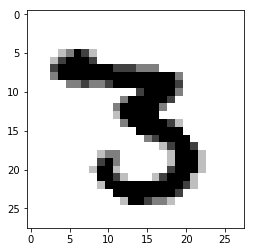

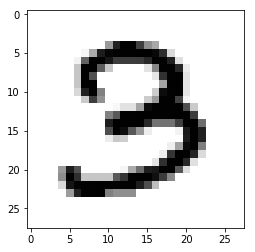

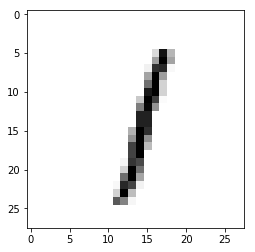

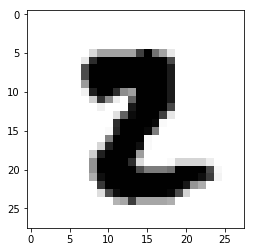

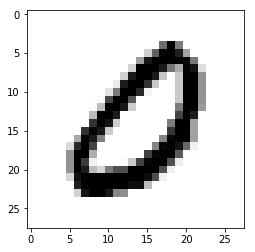

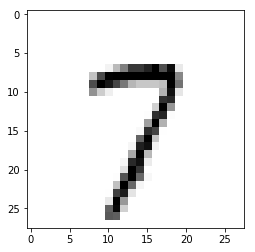

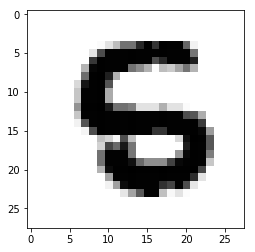

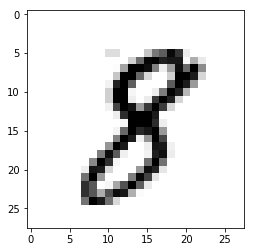

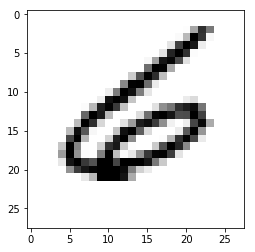

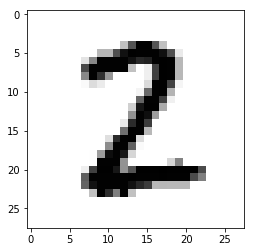

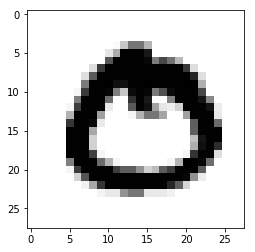

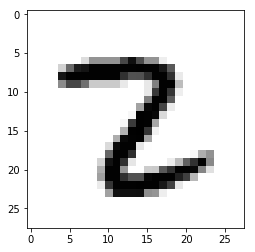

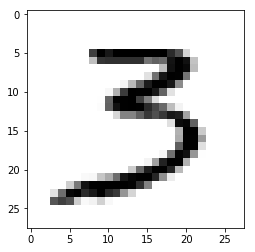

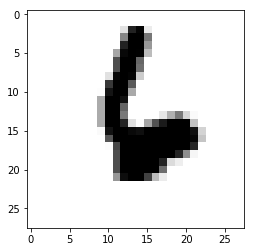

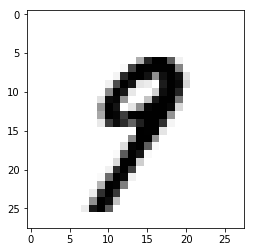

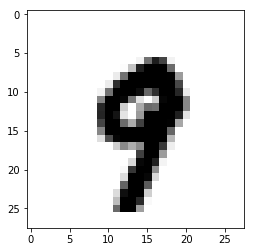

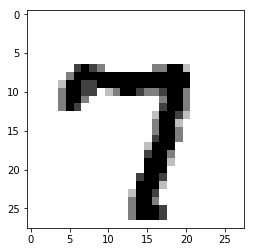

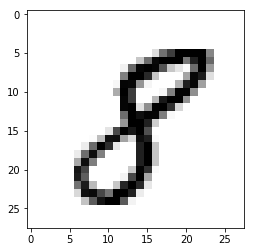

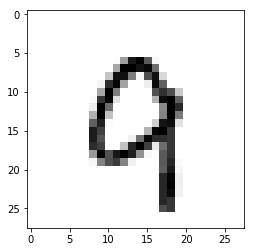

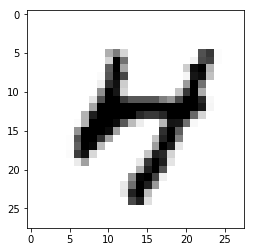

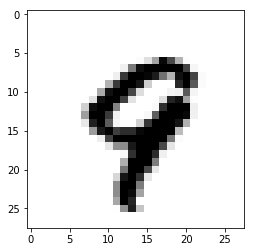

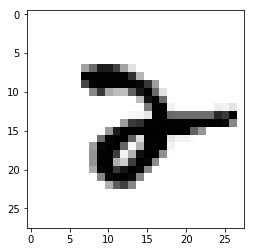

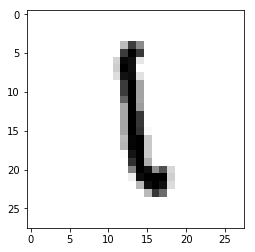

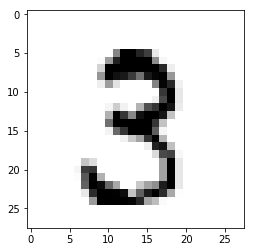

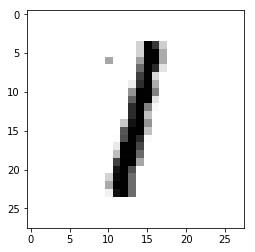

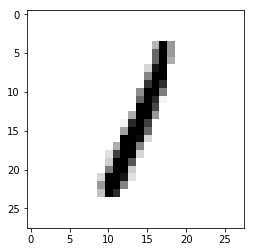

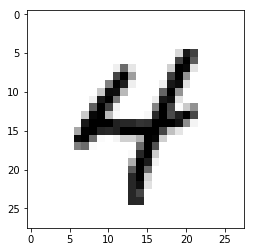

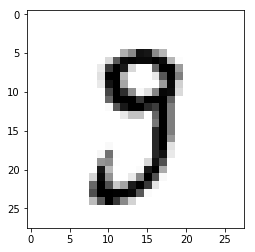

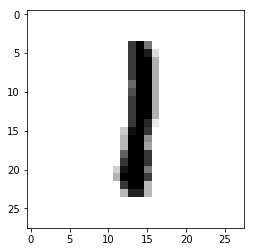

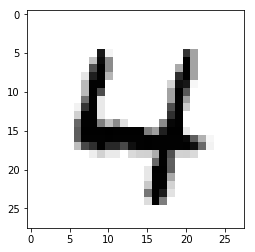

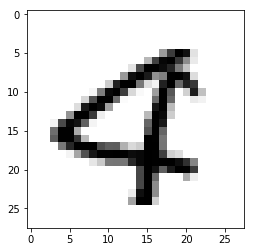

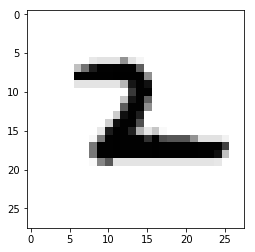

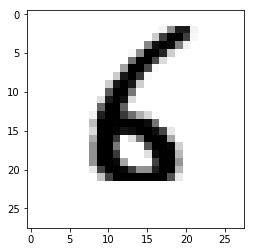

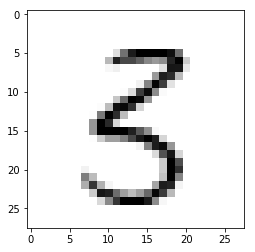

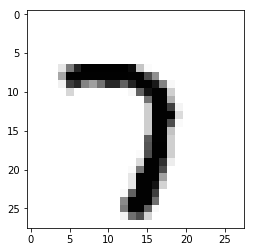

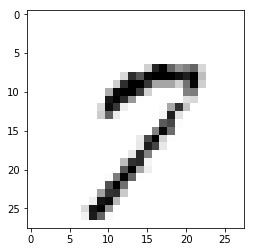

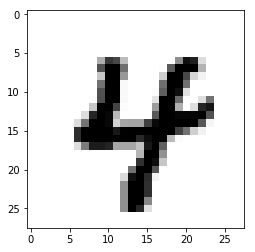

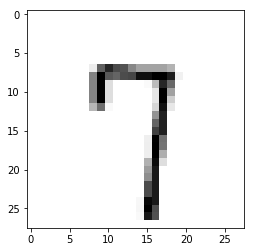

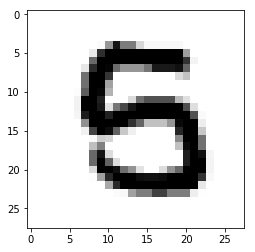

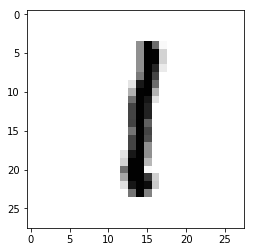

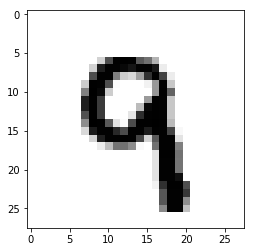

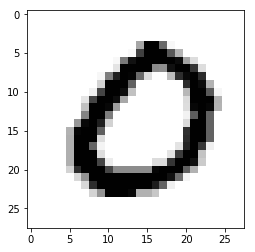

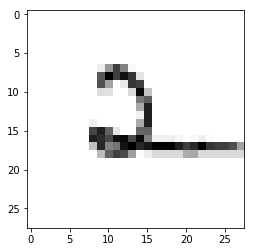

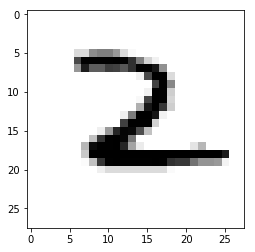

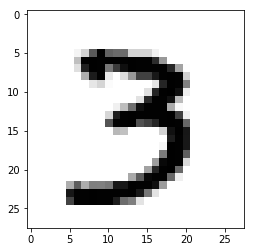

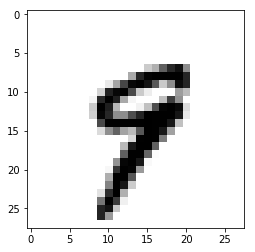

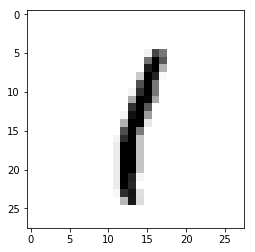

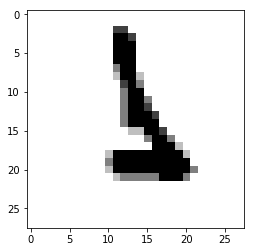

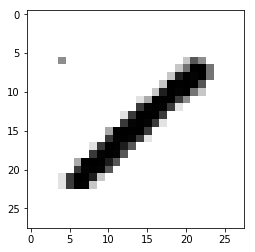

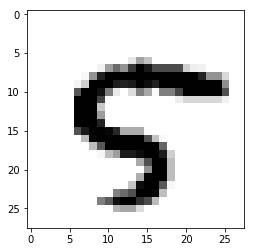

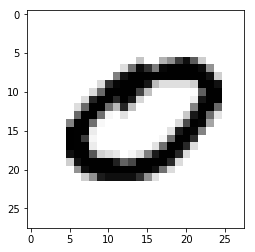

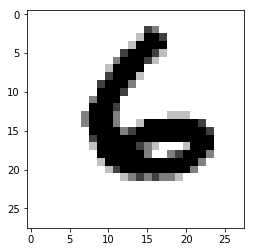

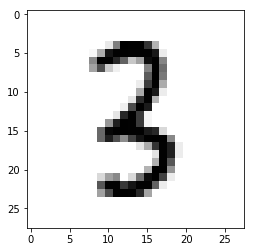

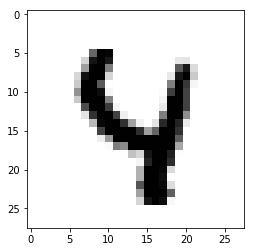

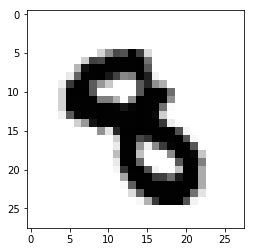

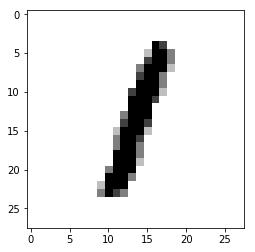

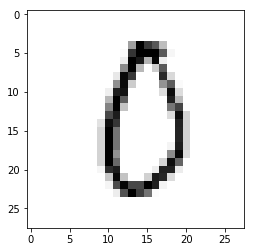

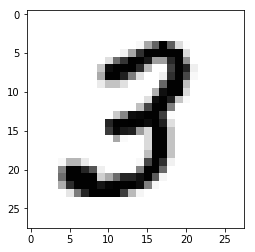

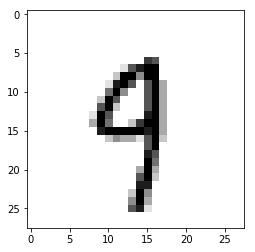

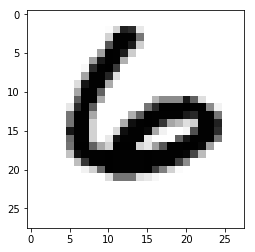

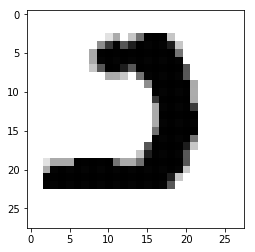

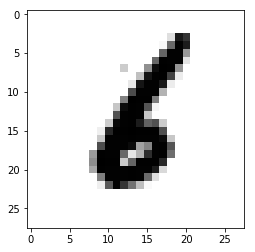

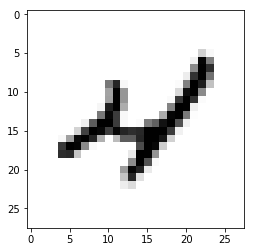

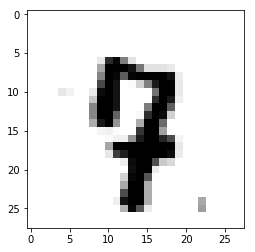

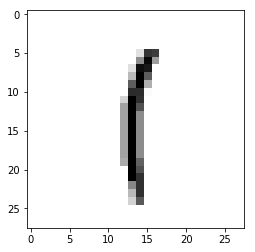

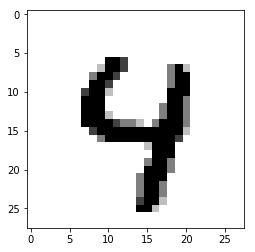

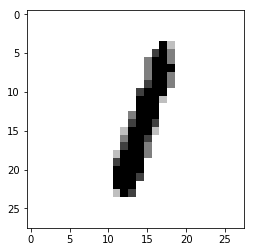

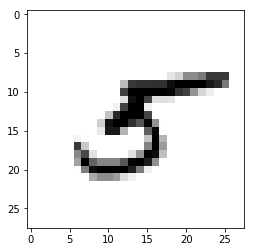

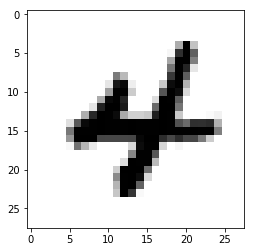

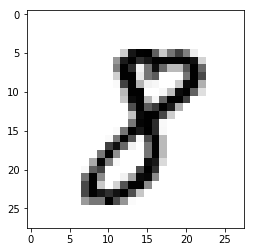

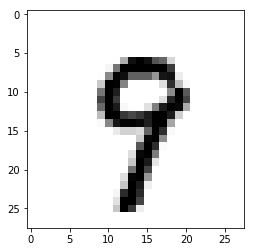

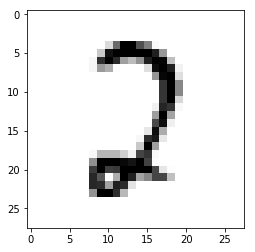

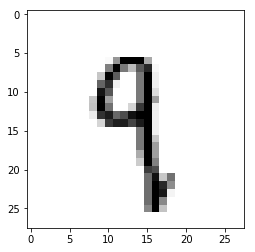

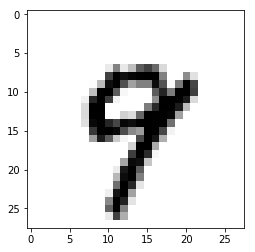

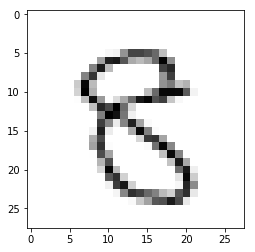

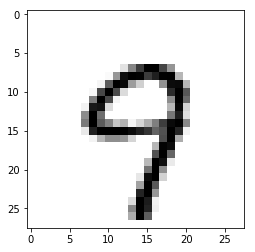

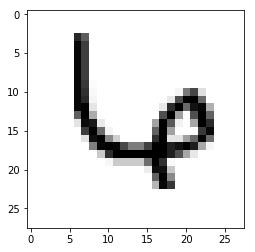

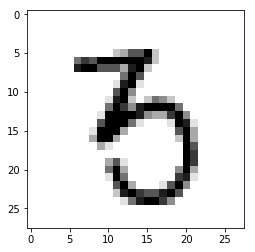

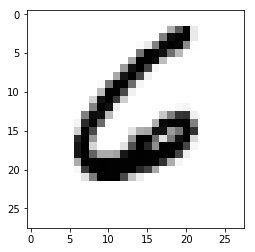

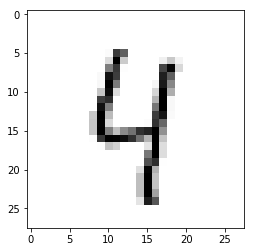

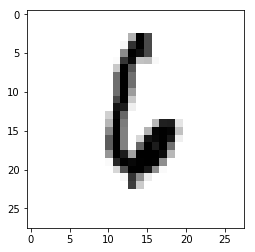

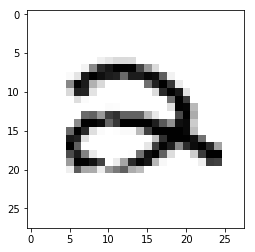

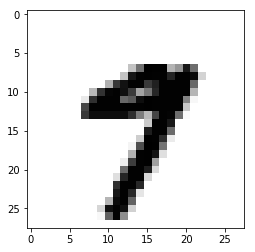

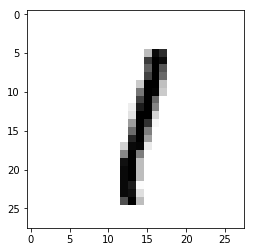

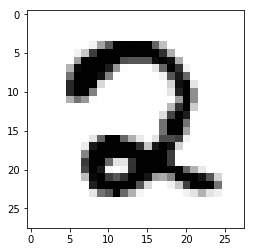

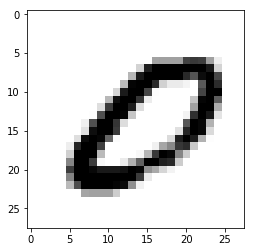

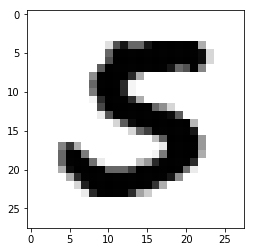

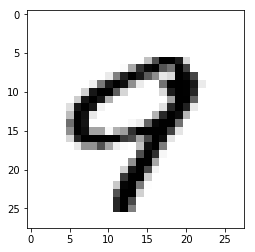

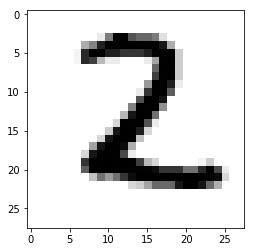

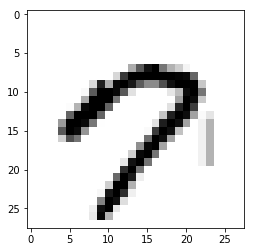

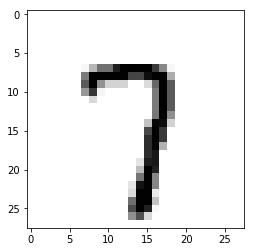

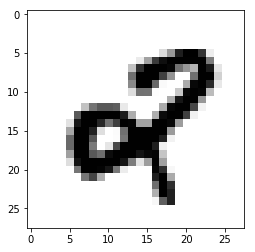

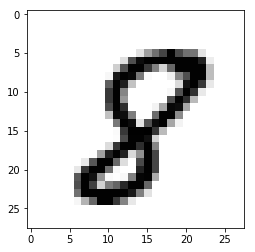

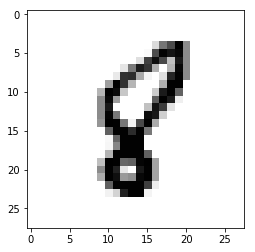

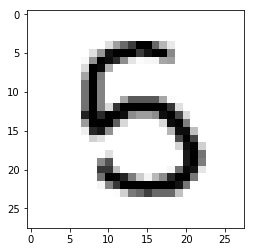

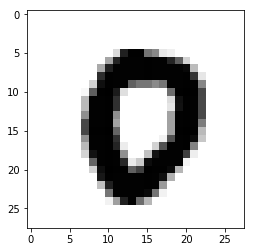

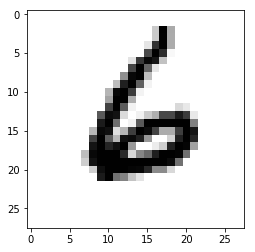

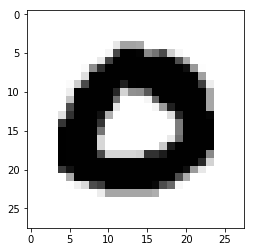

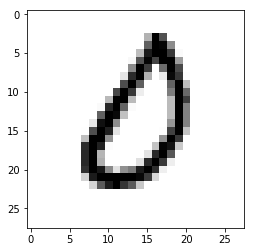

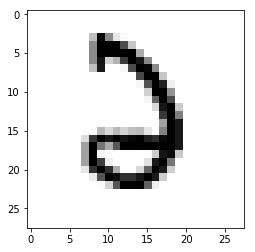

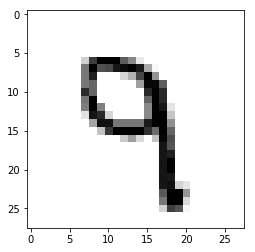

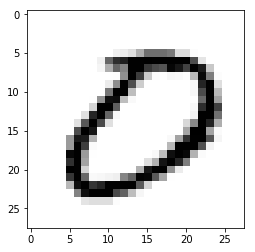

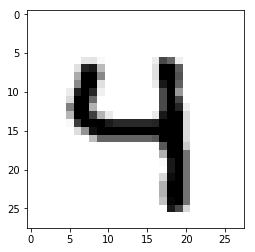

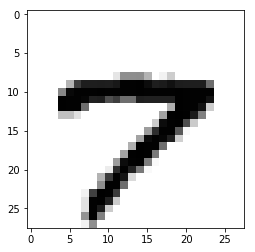

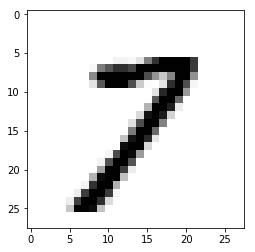

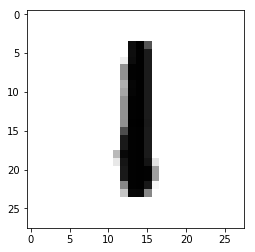

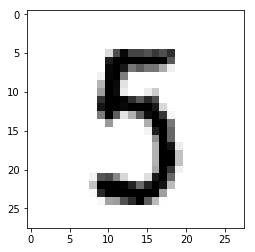

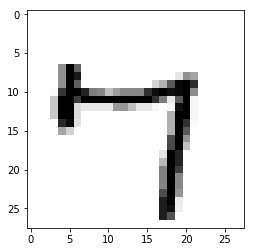

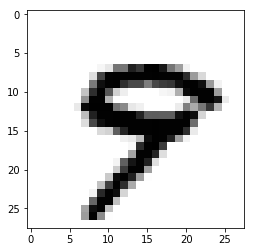

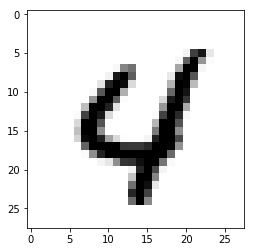

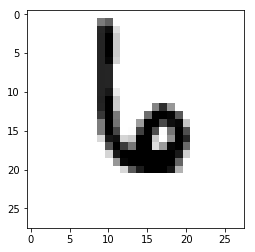

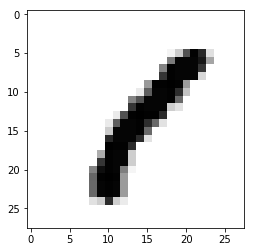

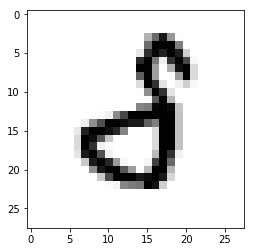

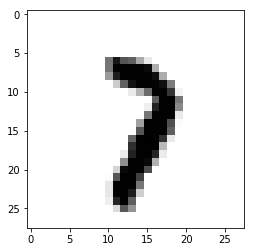

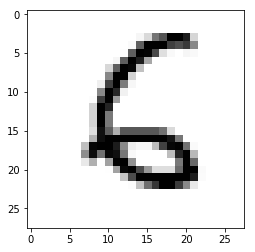

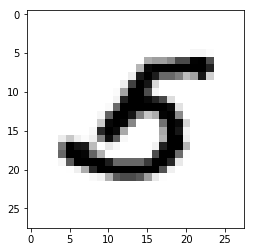

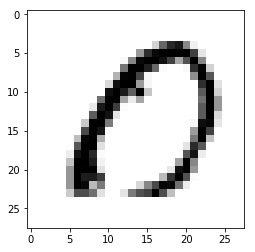

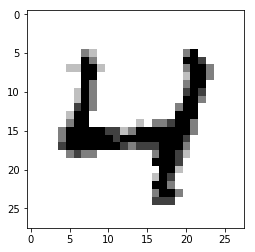

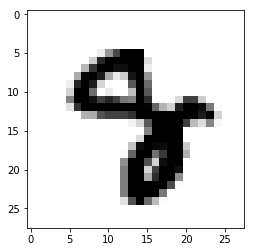

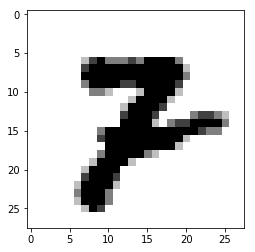

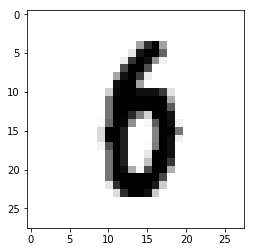

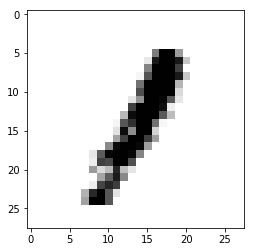

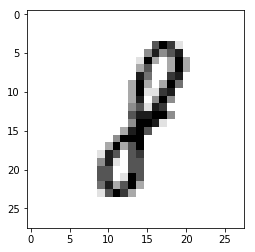

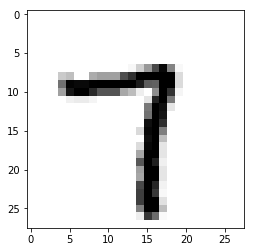

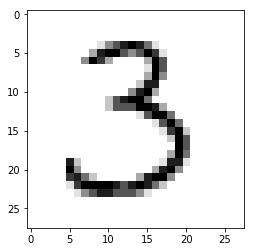

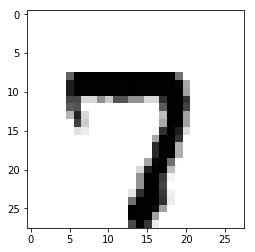

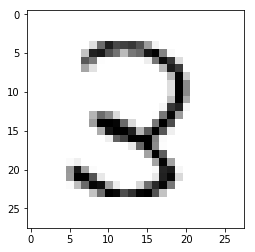

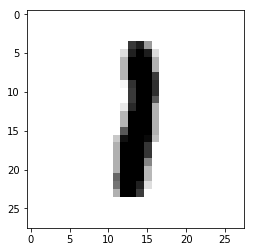

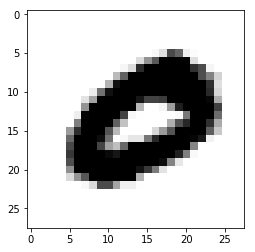

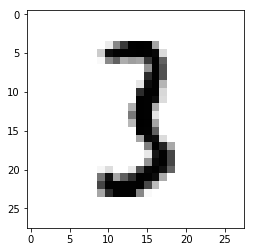

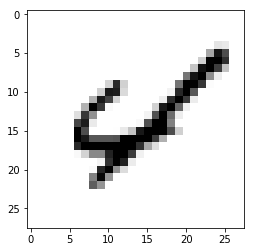

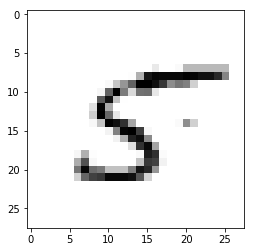

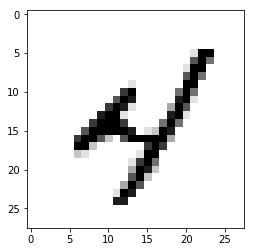

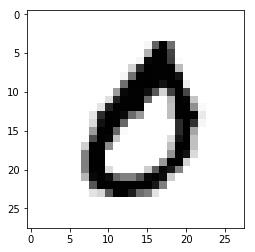

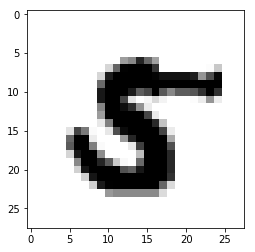

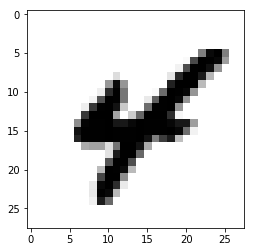

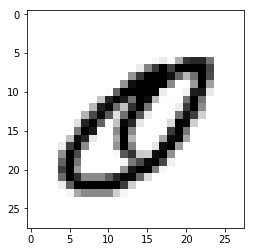

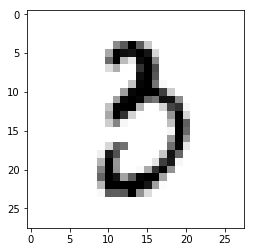

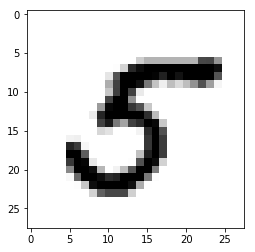

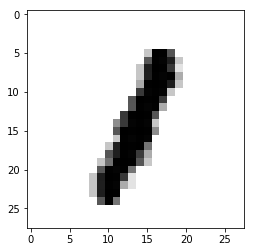

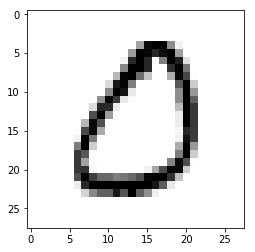

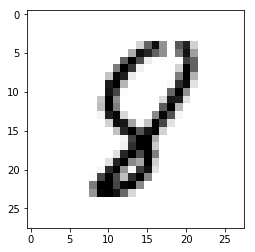

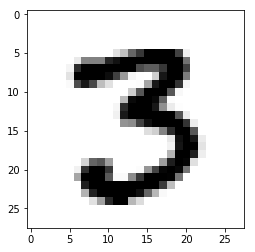

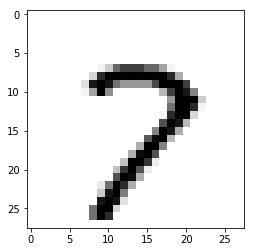

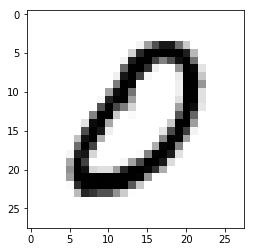

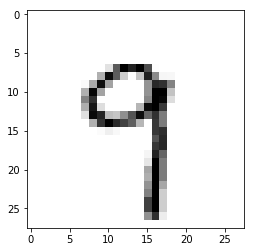

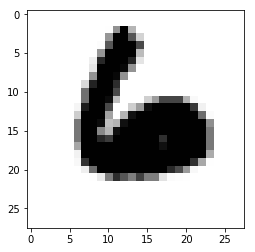

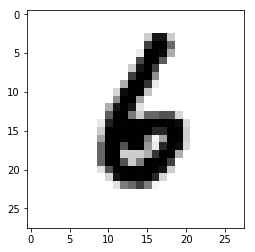

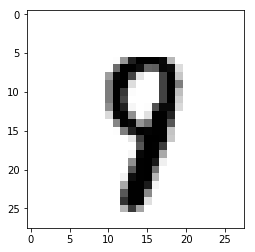

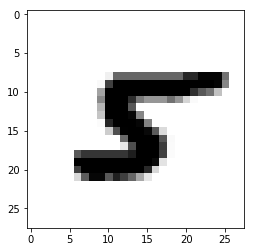

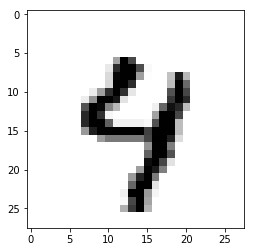

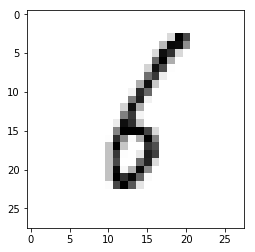

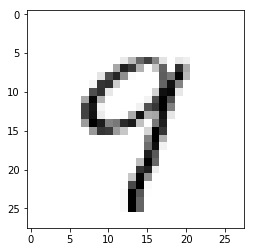

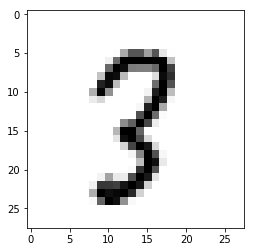

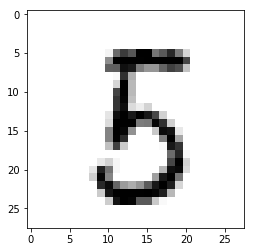

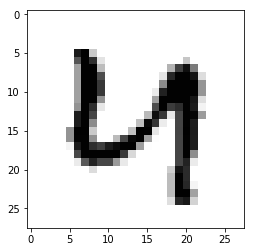

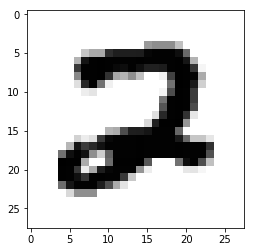

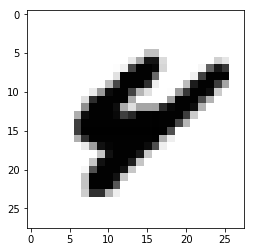

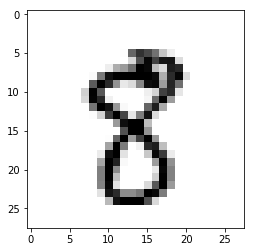

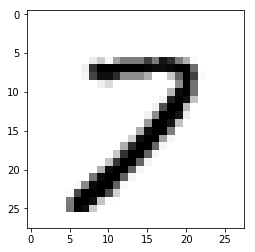

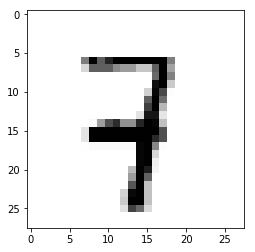

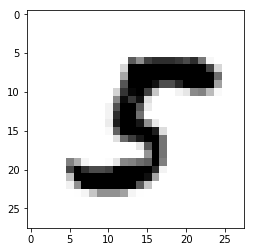

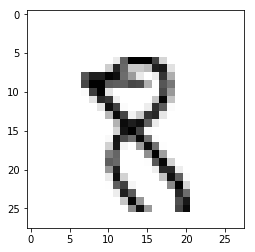

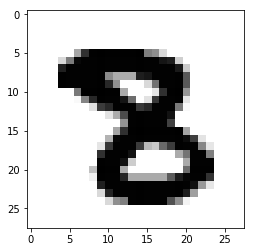

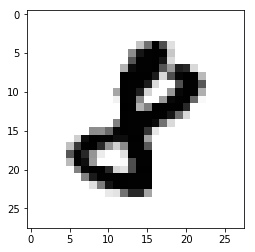

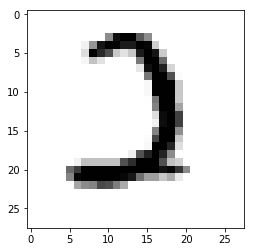

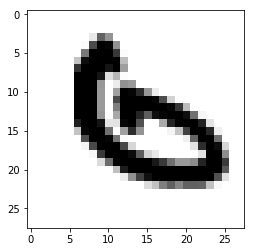

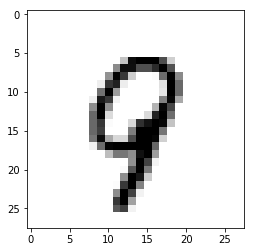

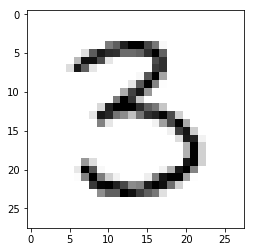

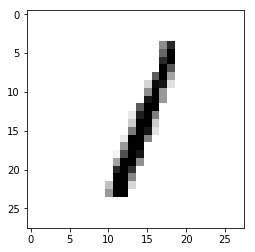

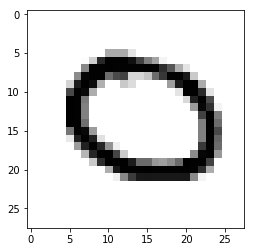

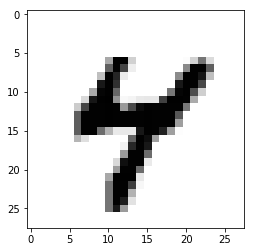

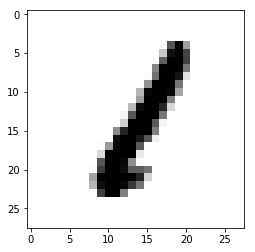

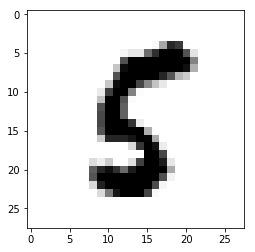

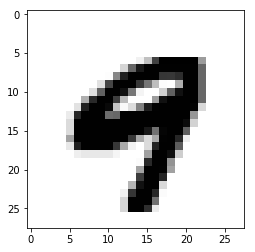

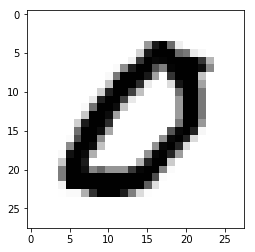

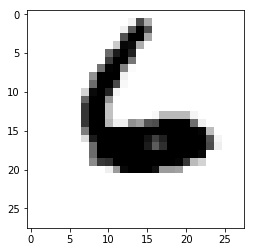

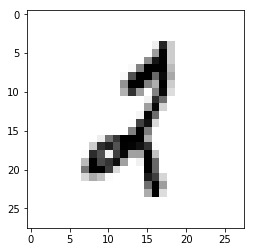

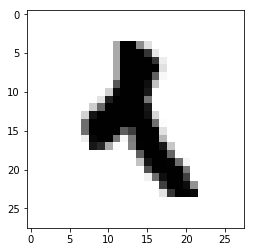

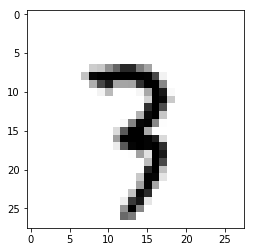

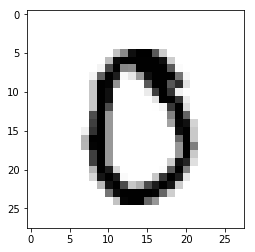

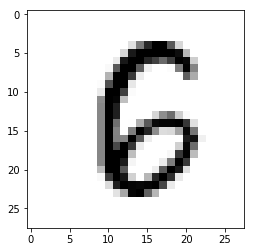

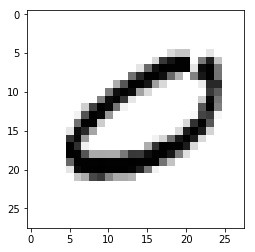

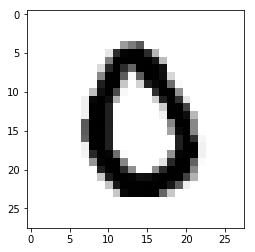

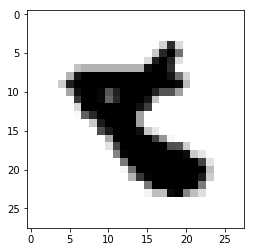

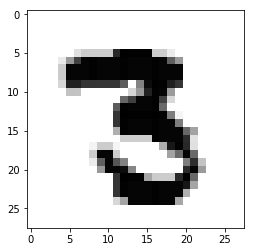

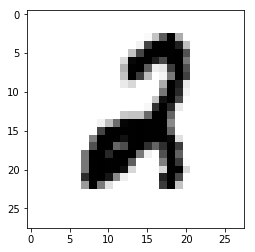

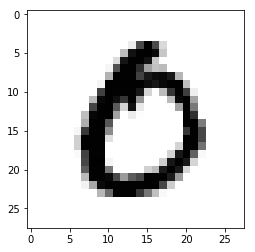

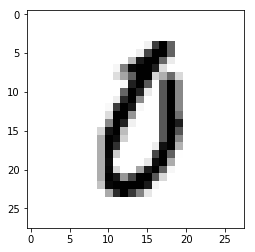

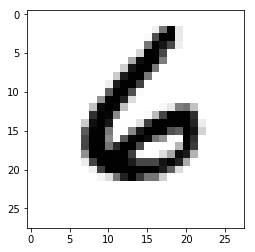

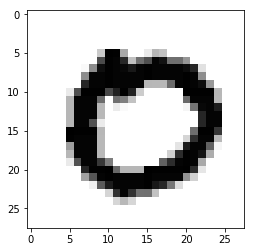

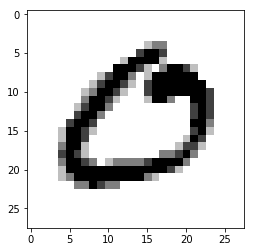

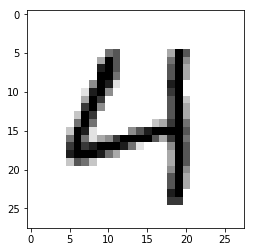

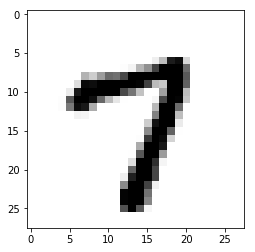

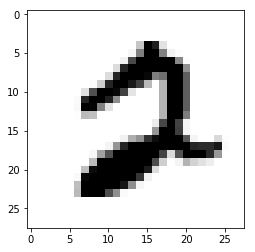

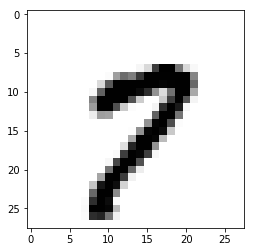

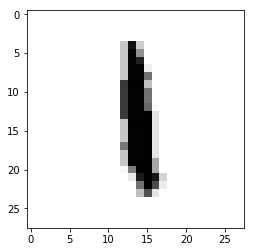

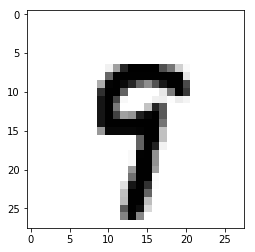

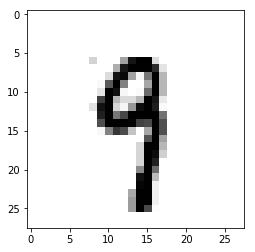

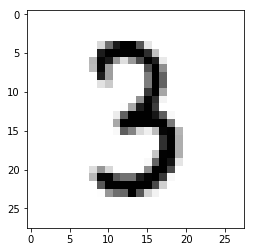

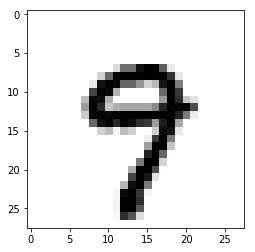

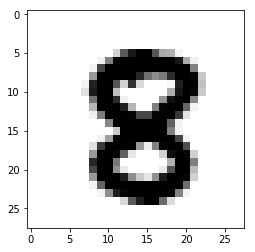

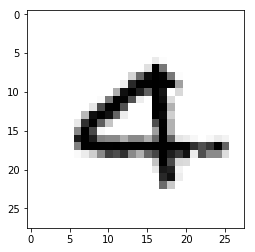

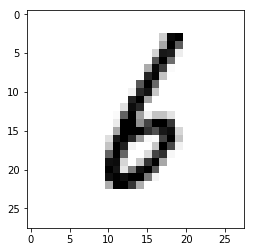

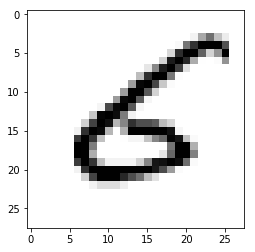

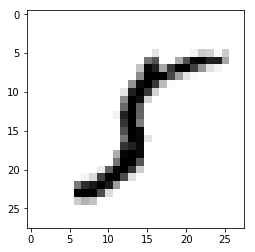

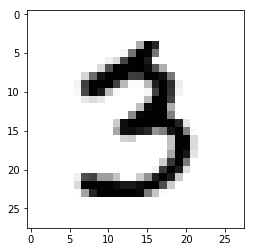

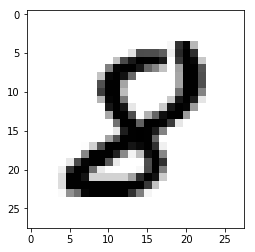

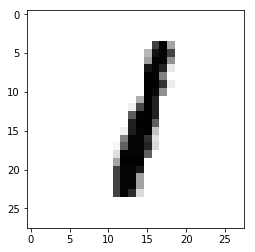

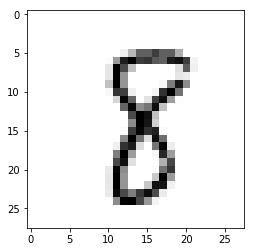

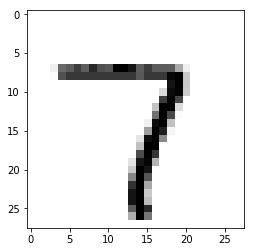

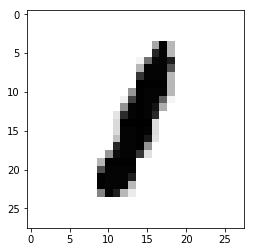

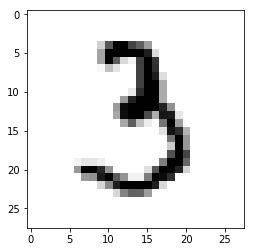

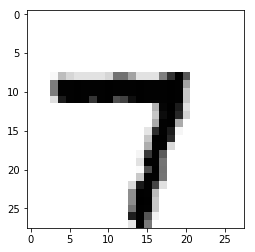

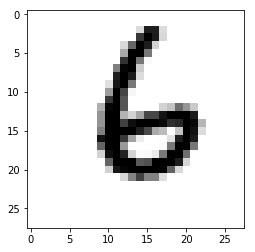

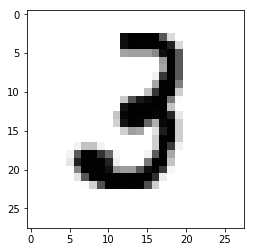

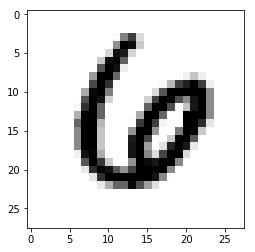

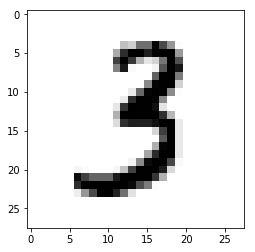

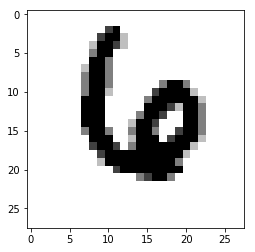

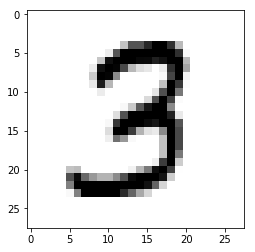

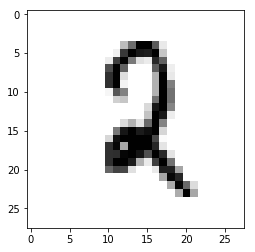

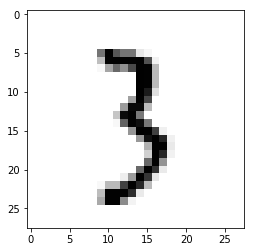

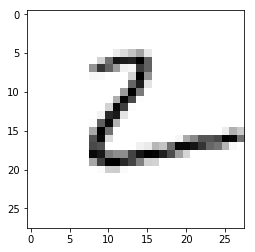

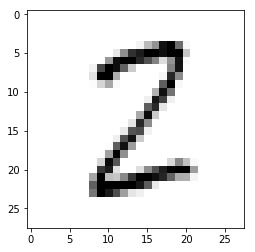

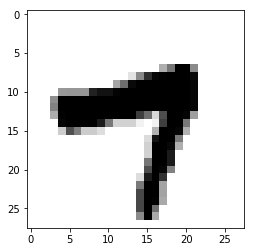

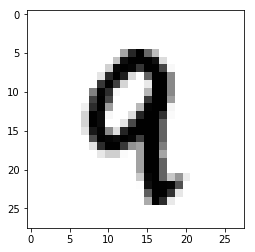

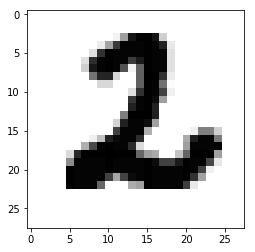

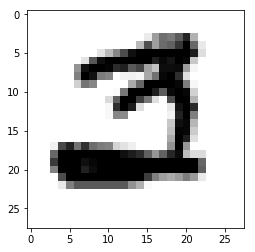

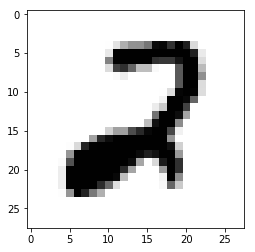

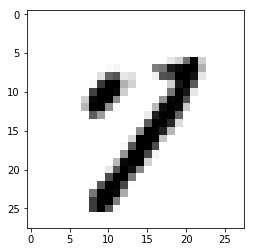

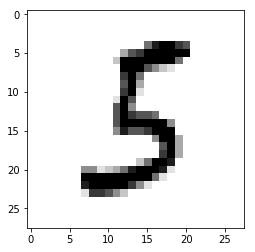

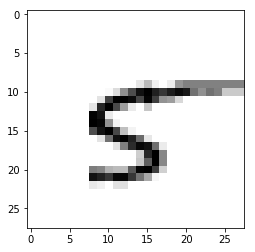

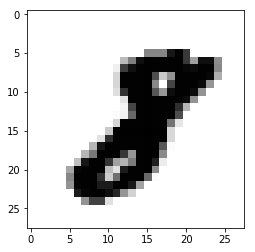

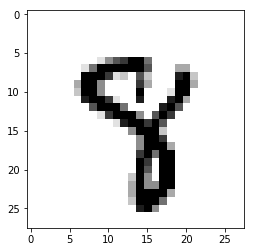

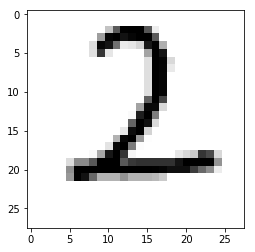

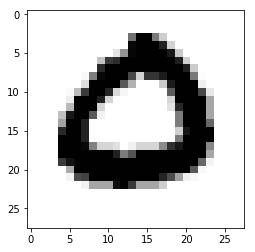

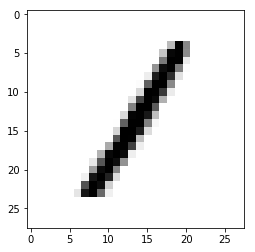

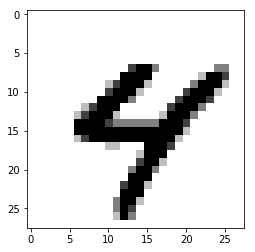

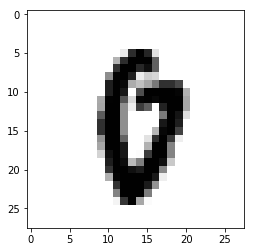

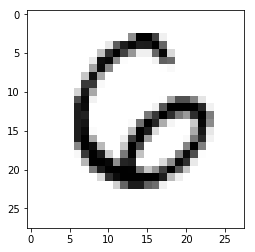

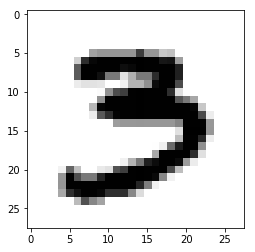

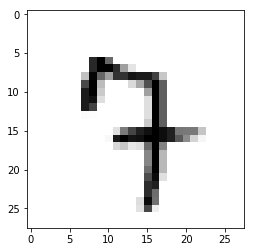

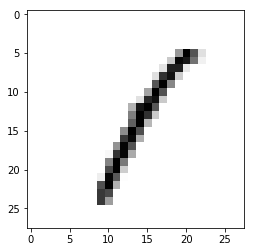

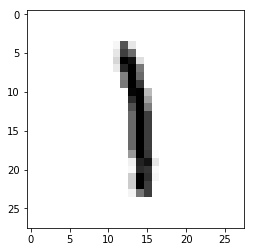

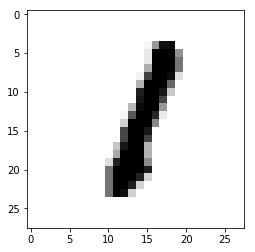

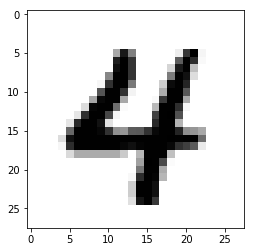

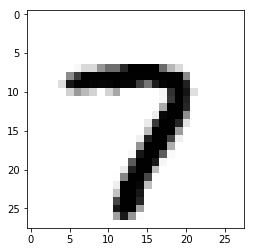

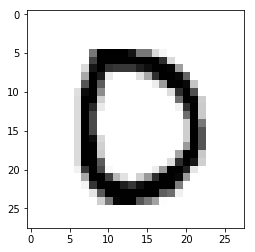

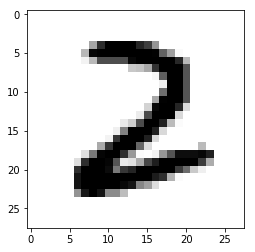

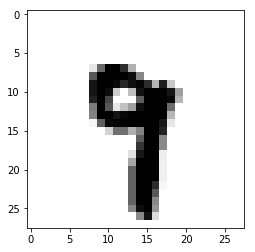

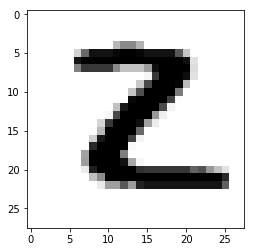

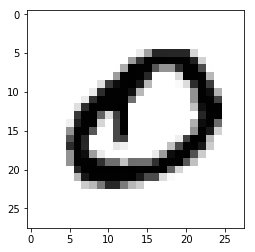

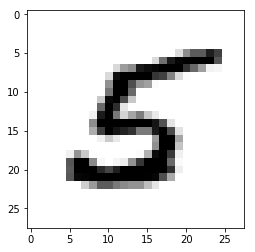

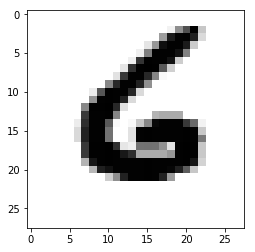

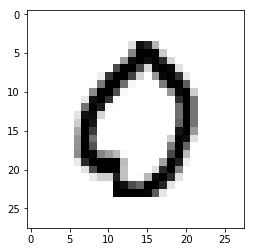

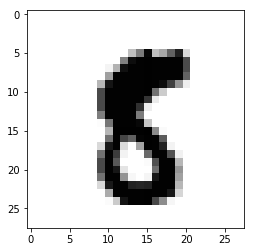

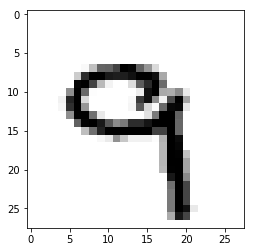

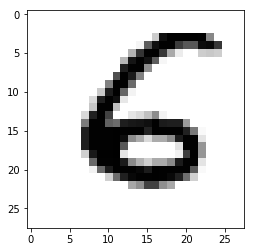

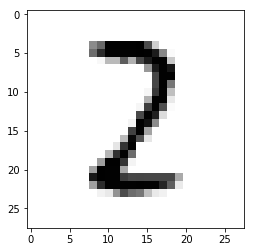

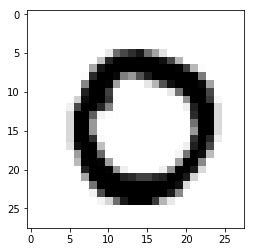

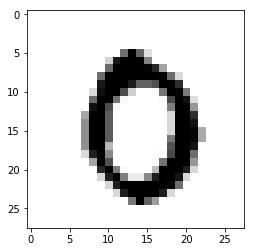

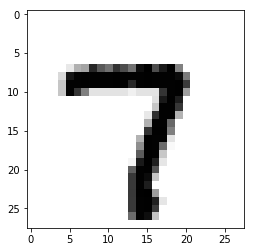

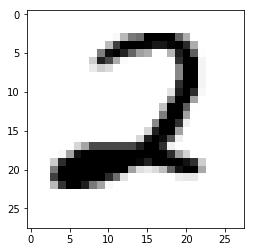

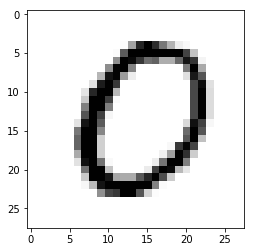

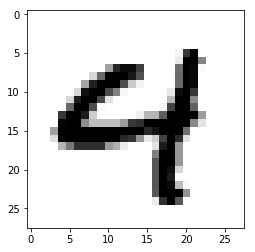

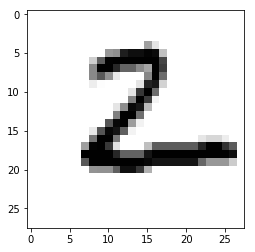

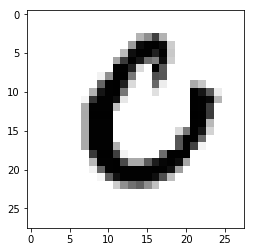

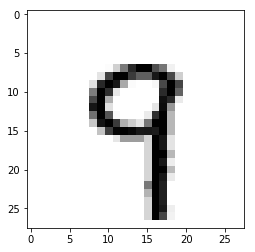

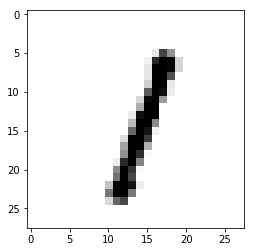

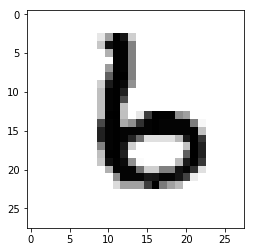

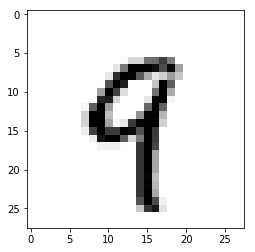

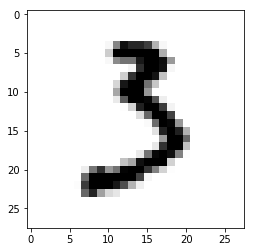

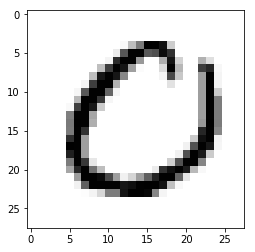

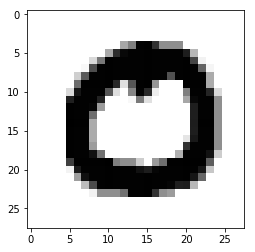

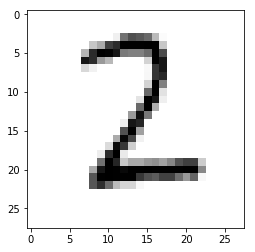

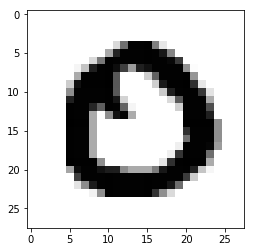

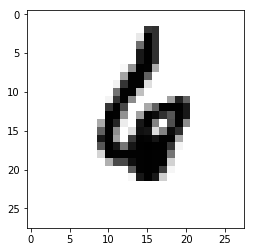

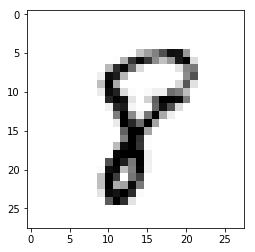

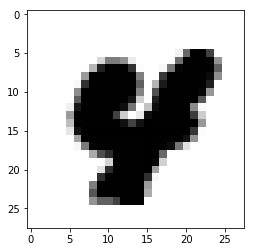

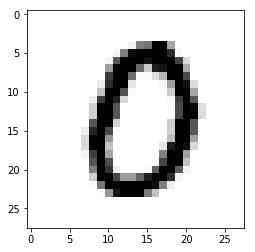

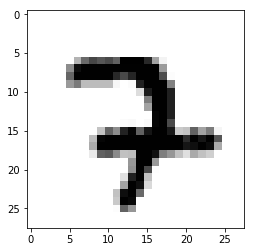

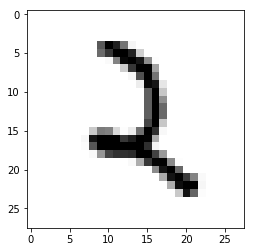

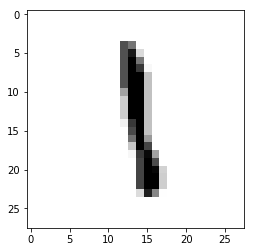

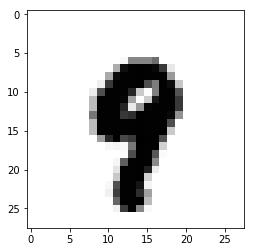

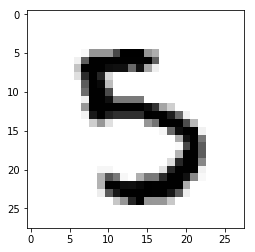

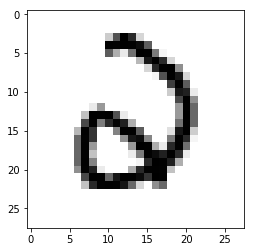

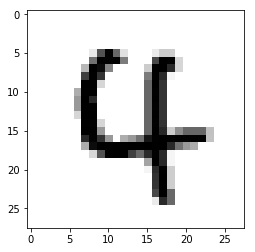

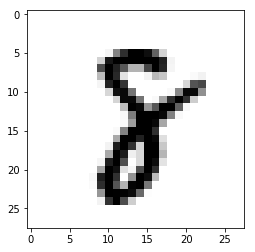

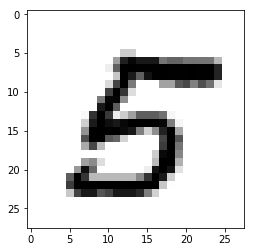

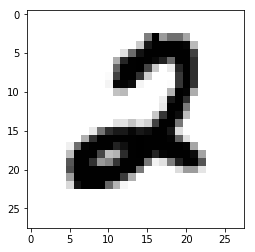

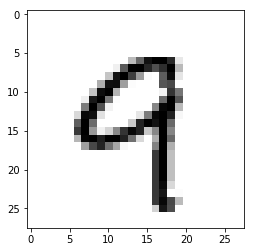

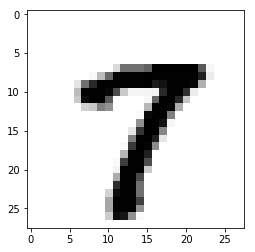

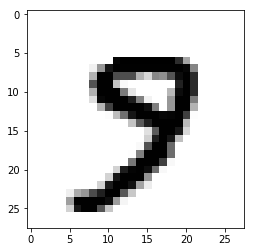

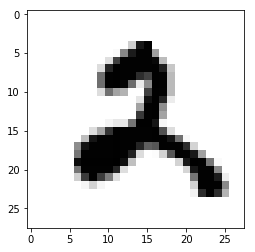

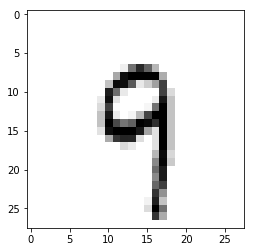

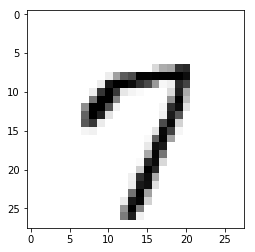

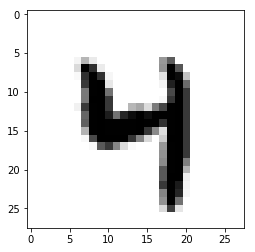

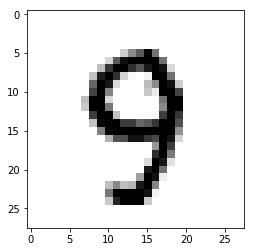

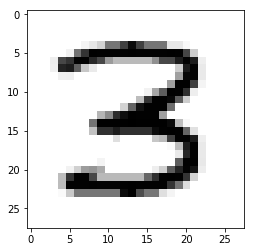

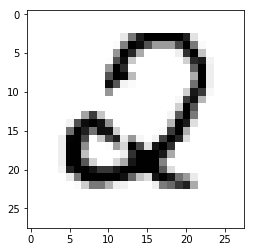

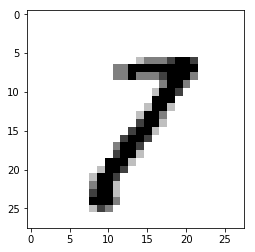

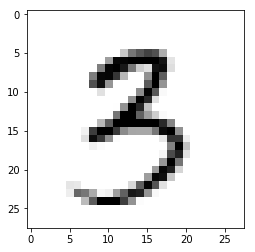

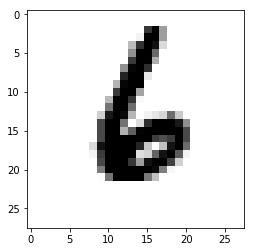

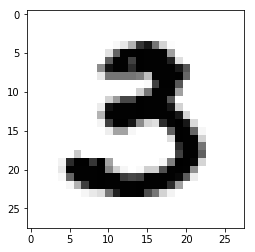

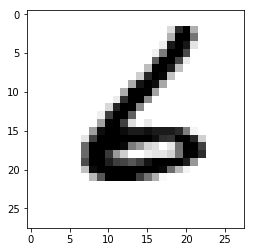

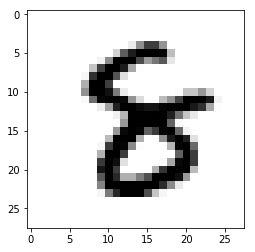

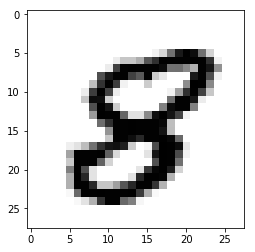

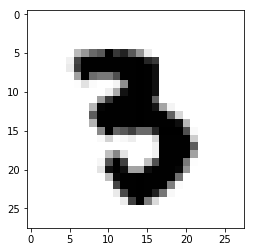

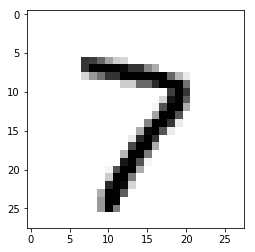

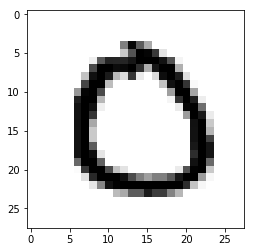

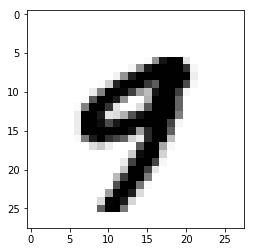

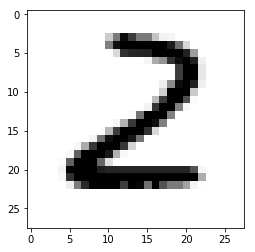

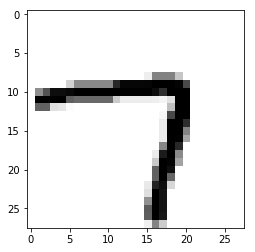

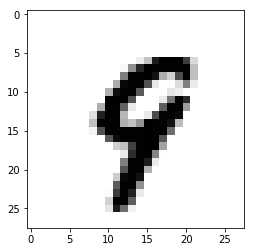

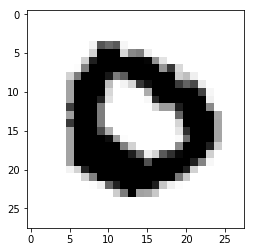

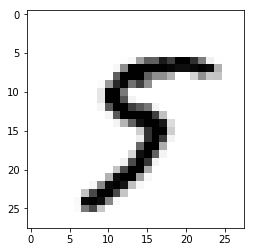

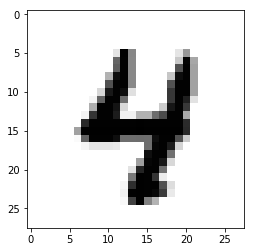

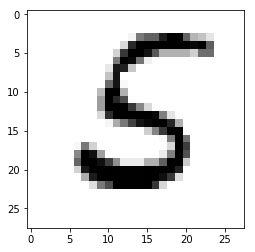

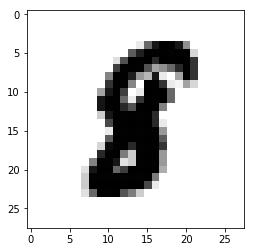

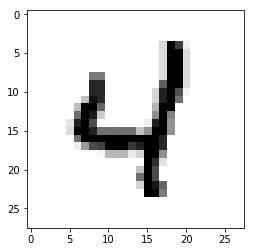

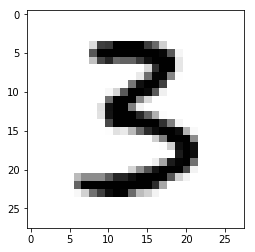

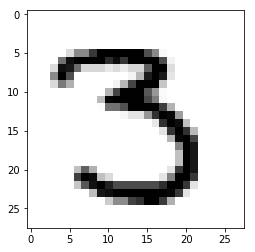

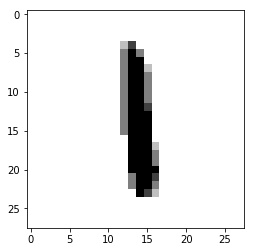

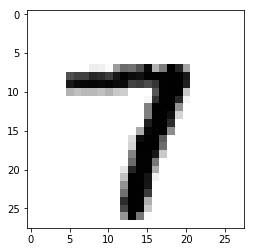

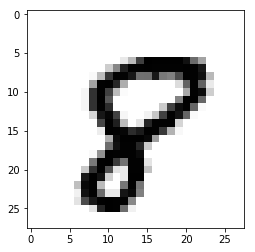

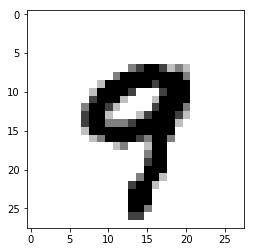

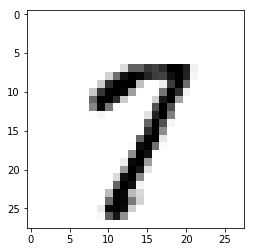

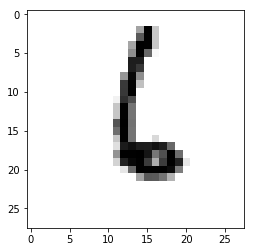

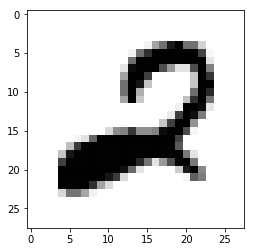

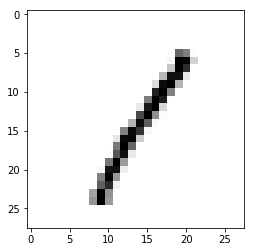

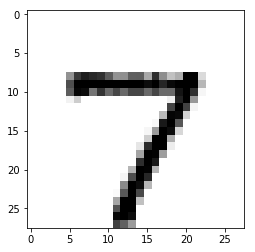

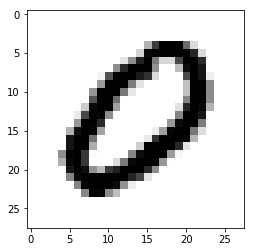

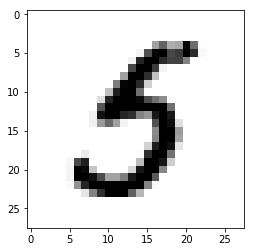

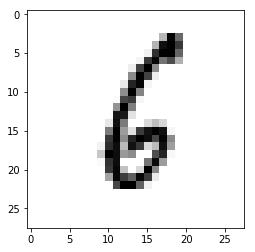

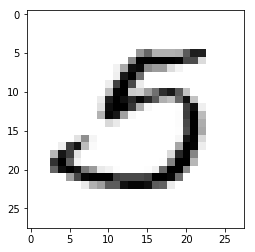

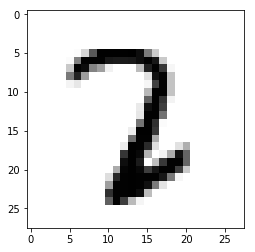

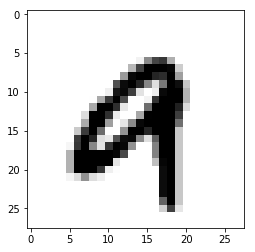

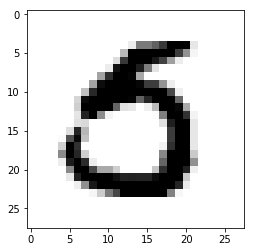

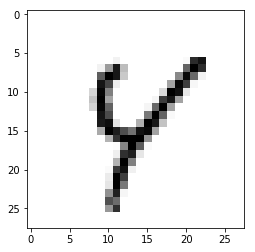

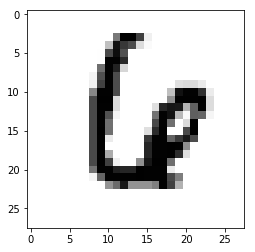

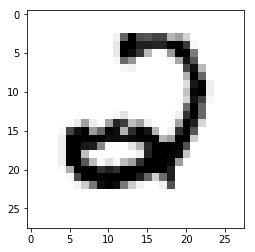

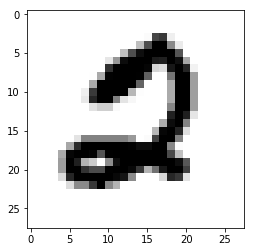

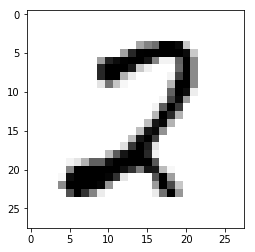

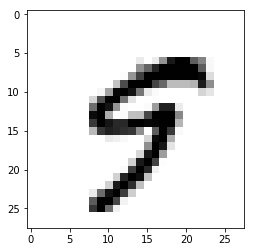

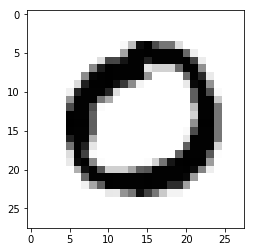

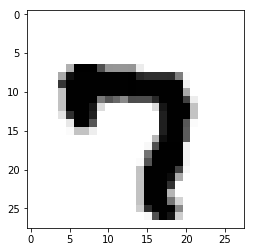

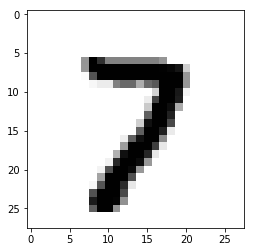

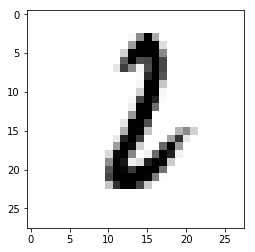

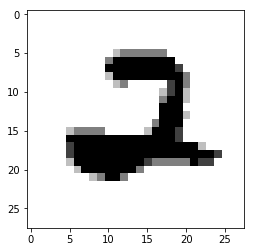

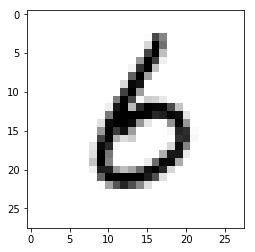

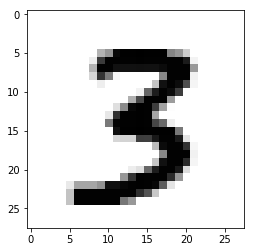

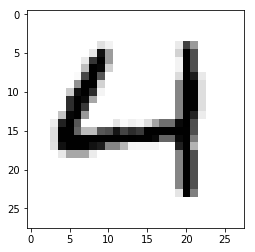

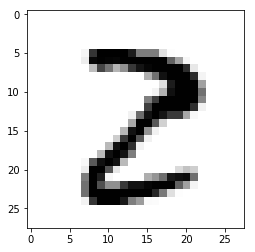

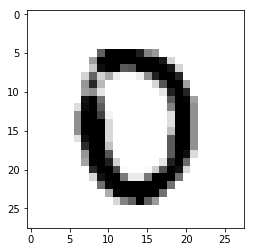

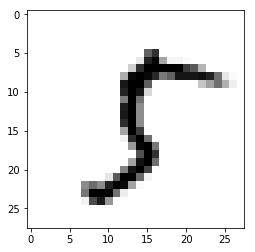

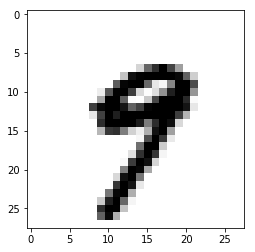

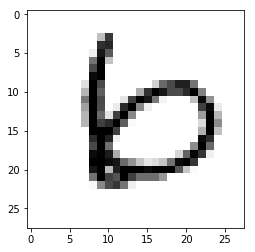

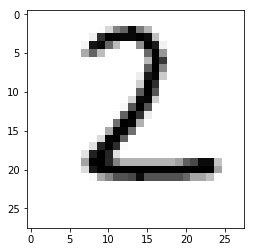

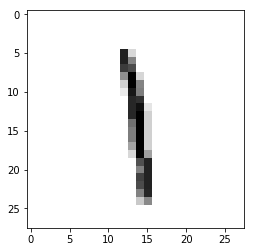

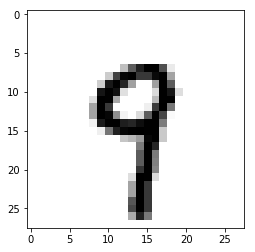

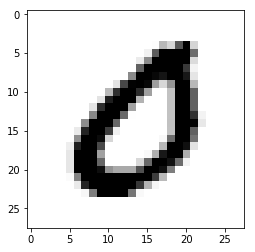

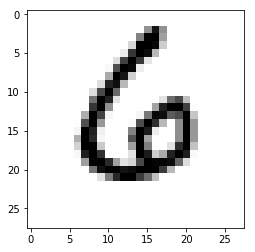

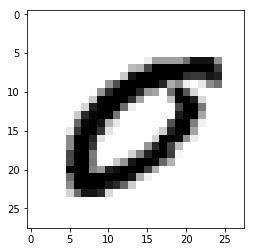

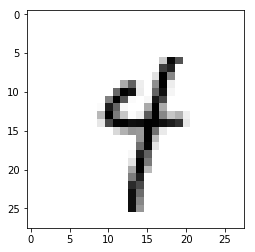

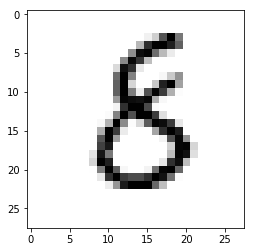

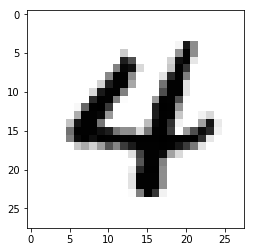

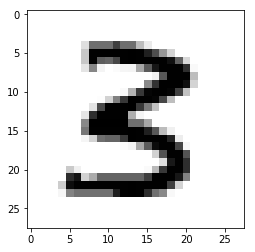

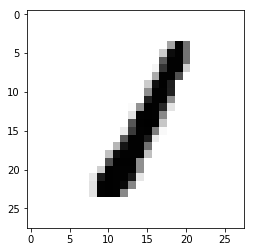

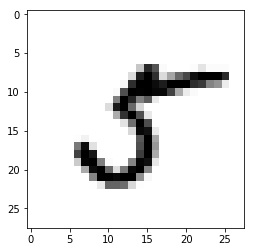

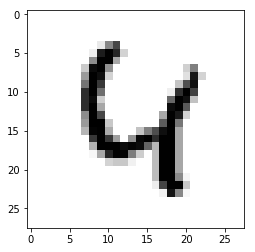

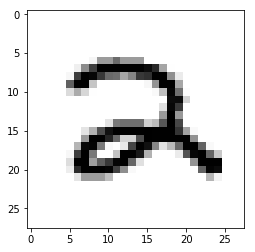

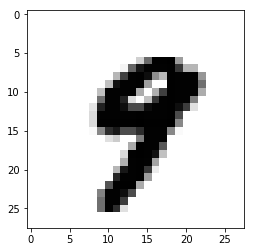

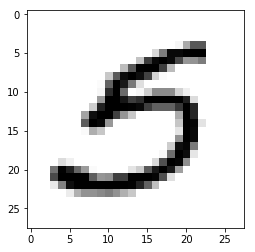

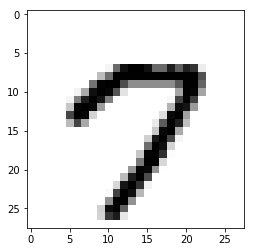

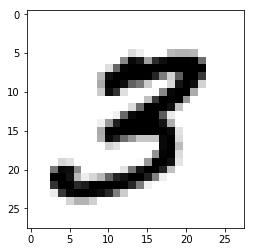

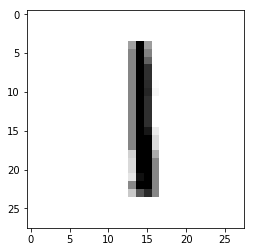

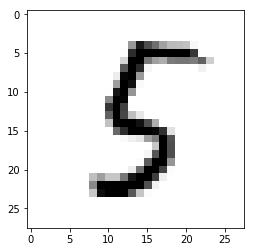

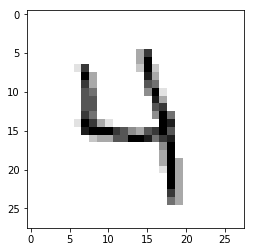

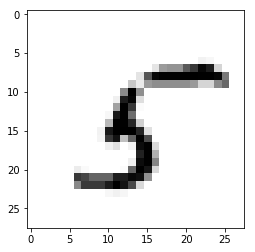

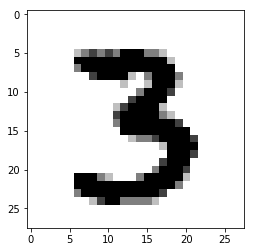

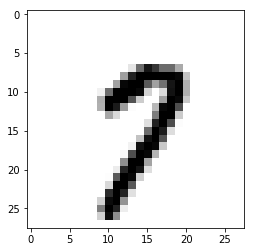

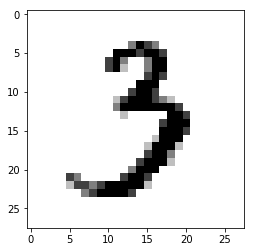

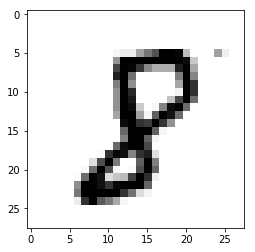

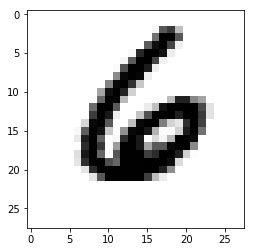

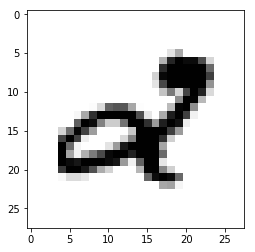

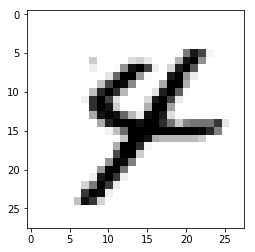

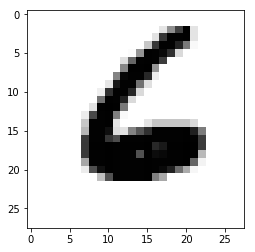

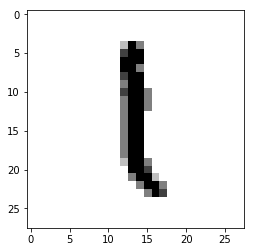

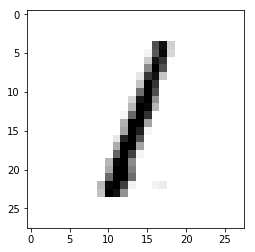

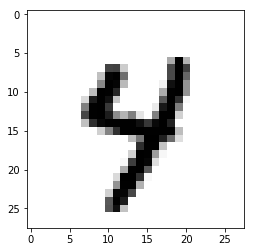

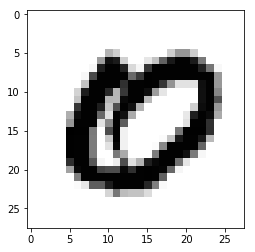

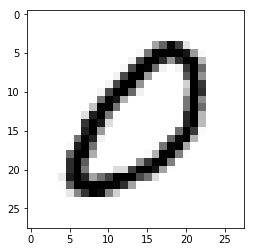

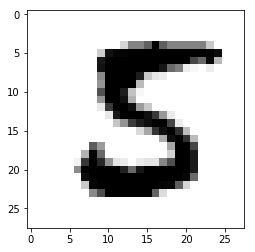

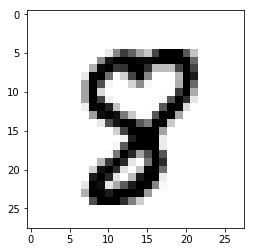

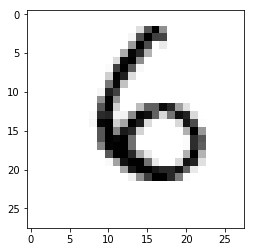

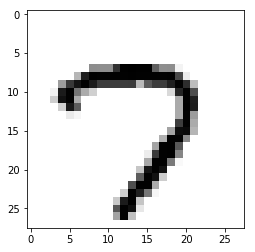

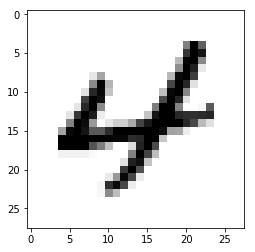

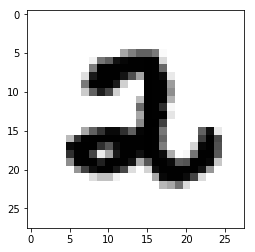

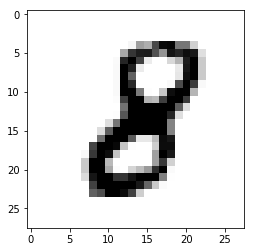

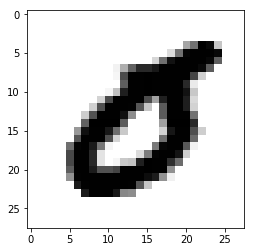

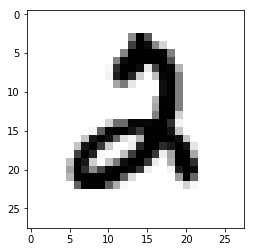

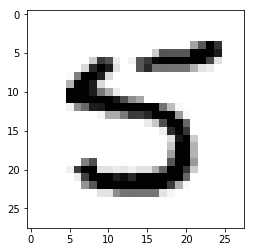

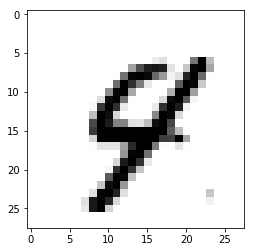

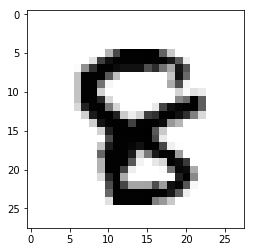

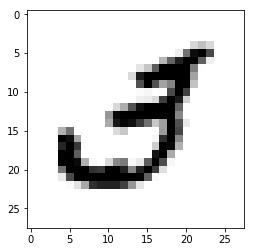

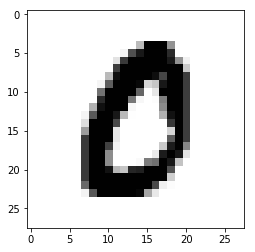

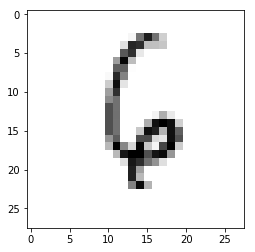

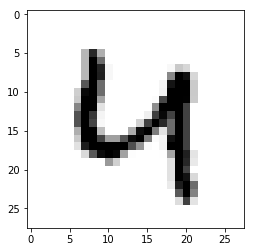

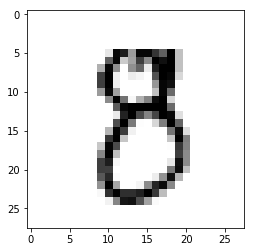

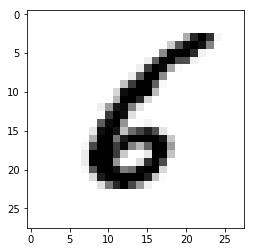

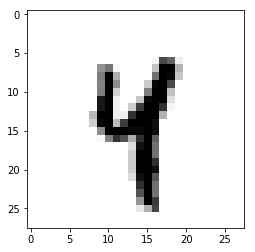

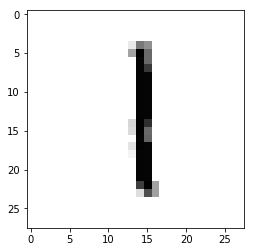

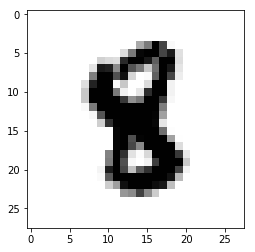

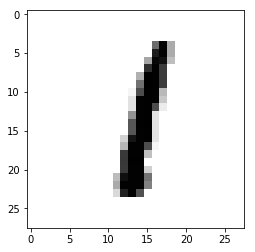

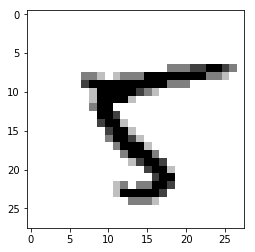

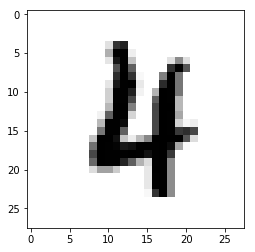

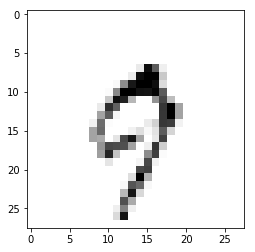

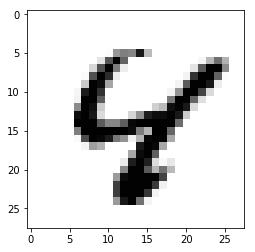

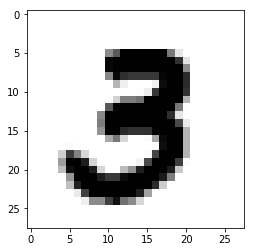

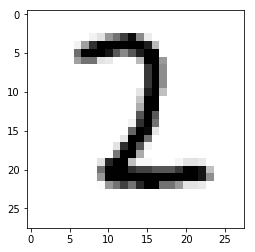

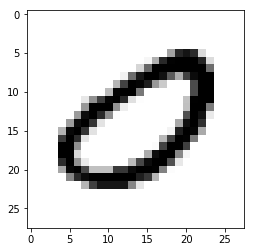

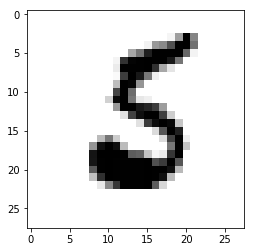

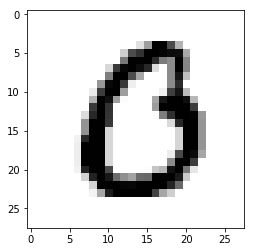

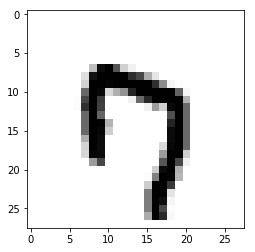

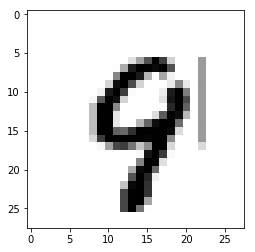

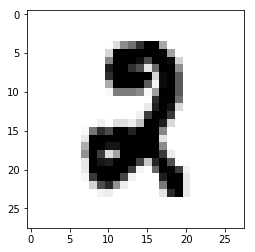

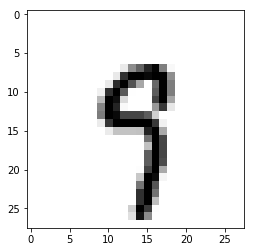

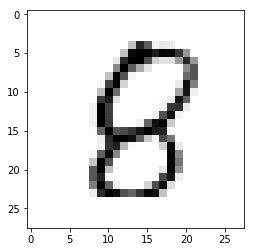

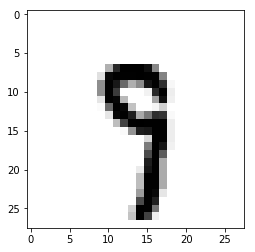

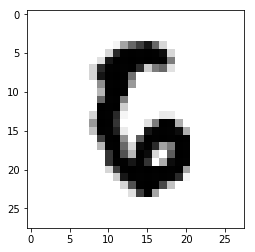

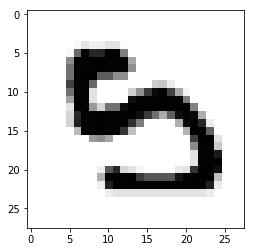

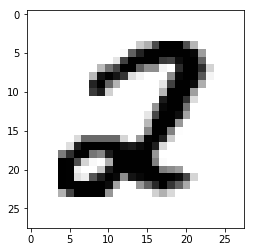

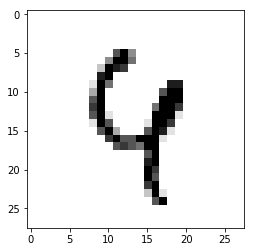

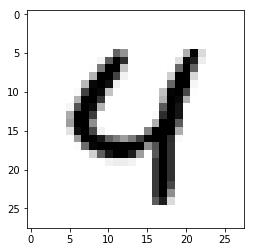

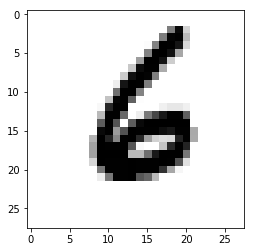

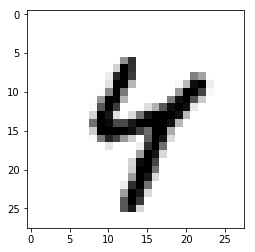

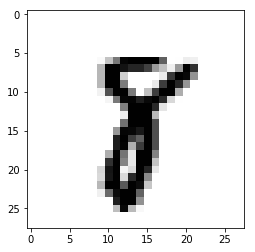

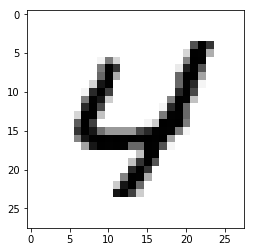

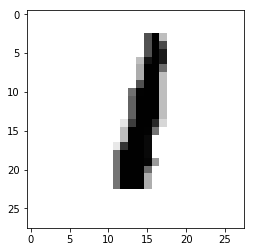

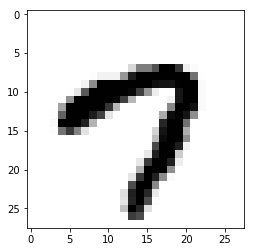

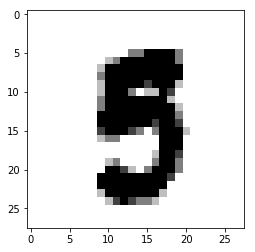

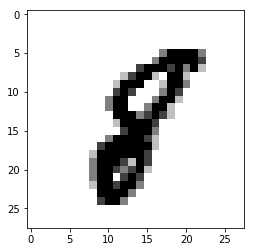

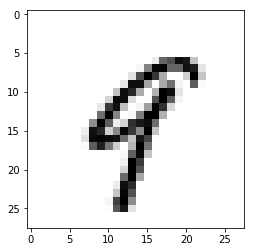

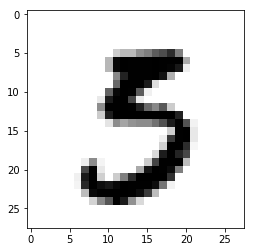

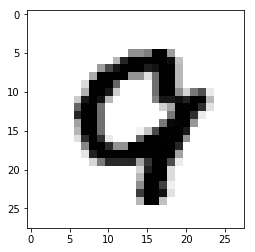

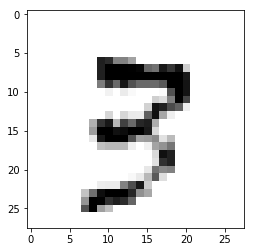

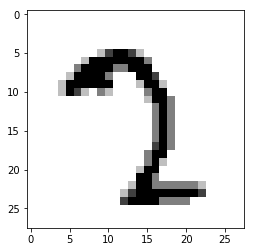

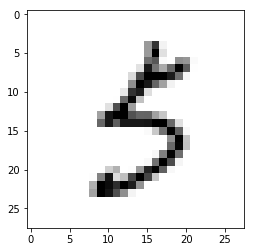

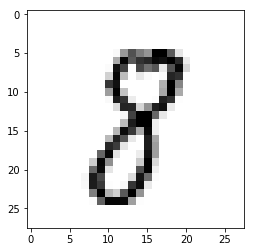

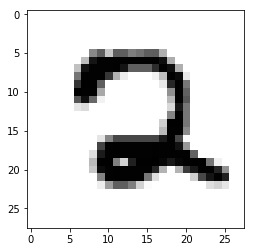

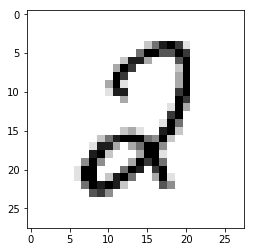

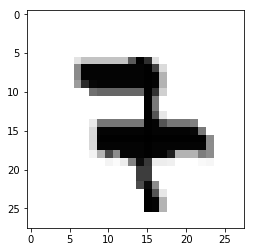

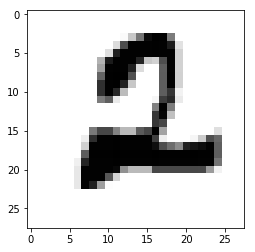

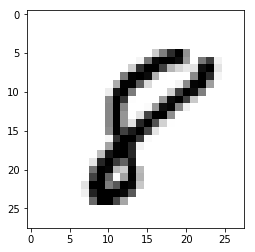

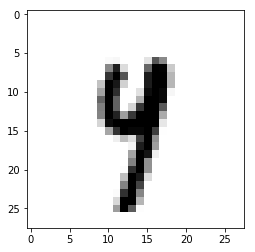

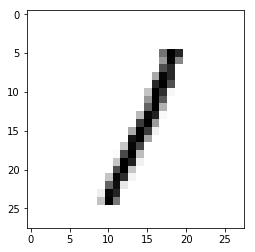

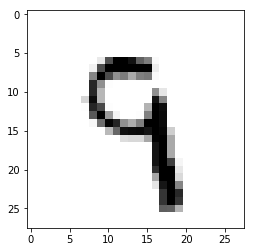

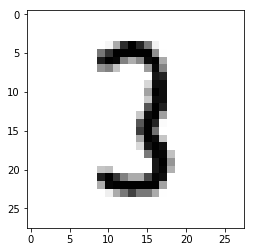

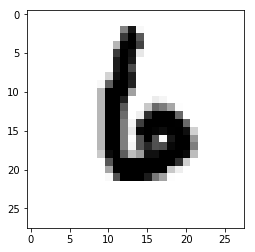

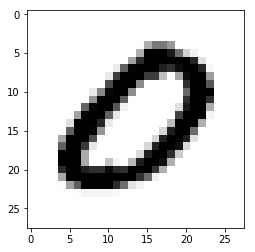

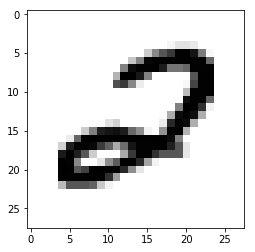

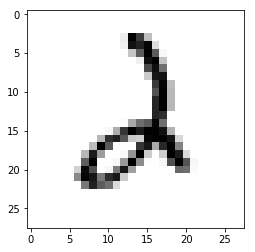

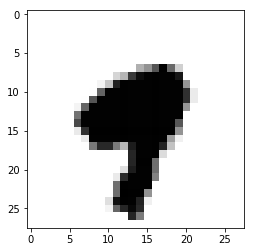

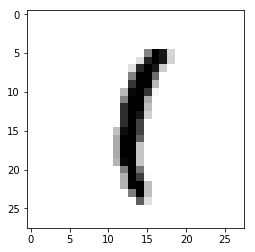

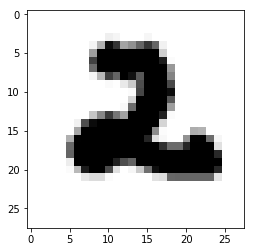

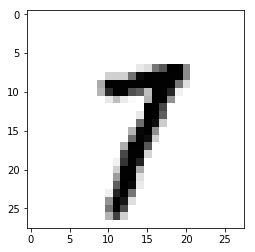

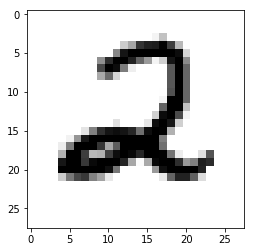

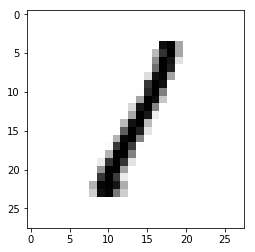

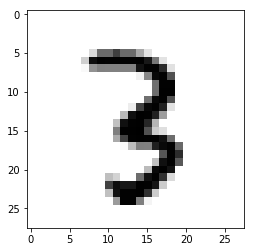

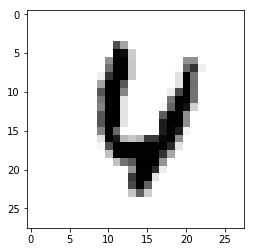

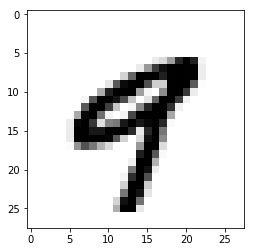

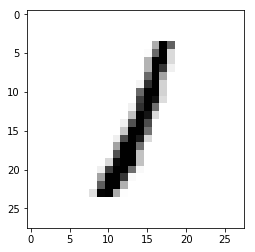

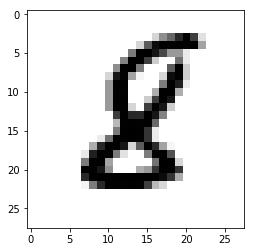

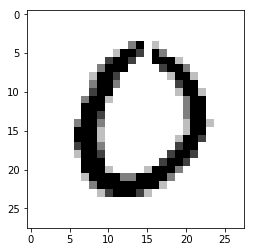

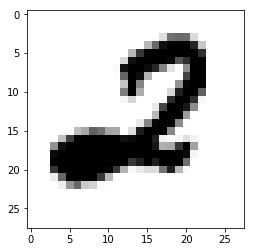

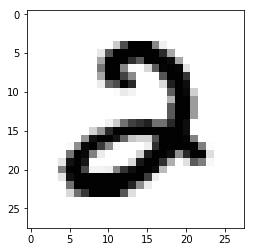

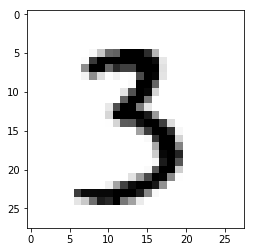

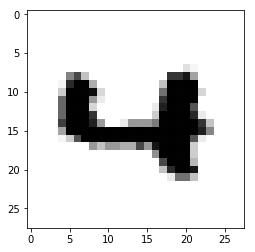

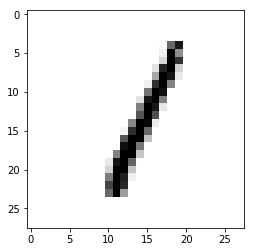

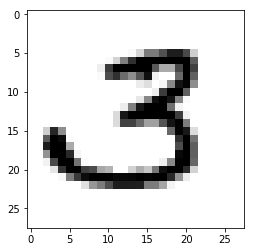

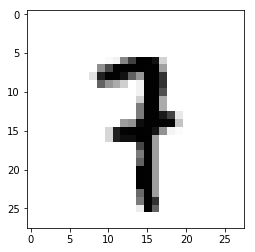

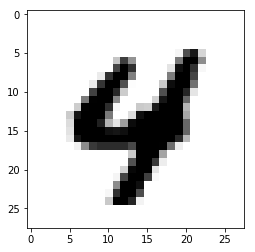

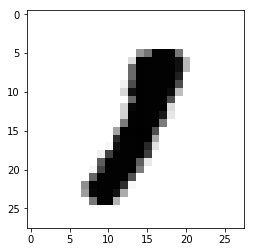

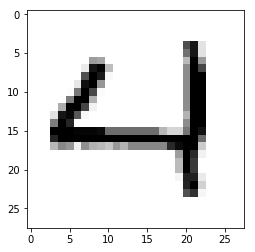

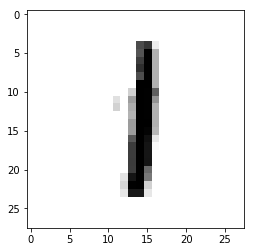

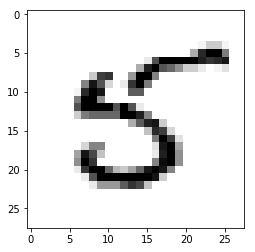

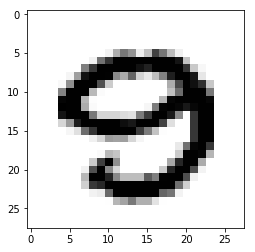

In [15]:
# save some fig
for i in range(500):
    fig_data = fig_datas.iloc[i]
    fig, ax = plt.subplots()
    ax.imshow(transformDataFrameFromSeries(fig_data), cmap=plt.cm.gray_r)
    plt.savefig('./figs/' + str(i) + '-' + str(label_datas[i]) + '.png')

可以看到不同图的有效区域有差异，同时有些图还有旋转的效果。

有没有必要对数据作进一步降维处理？

直接上random forest试试效果吧

### 训练

In [21]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)

rf.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [23]:
test_label_datas = rf.predict(test_data)
test_fig_datas = test_data / 255

/home/cyl/project/virtualenv/tensorflow/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  import sys


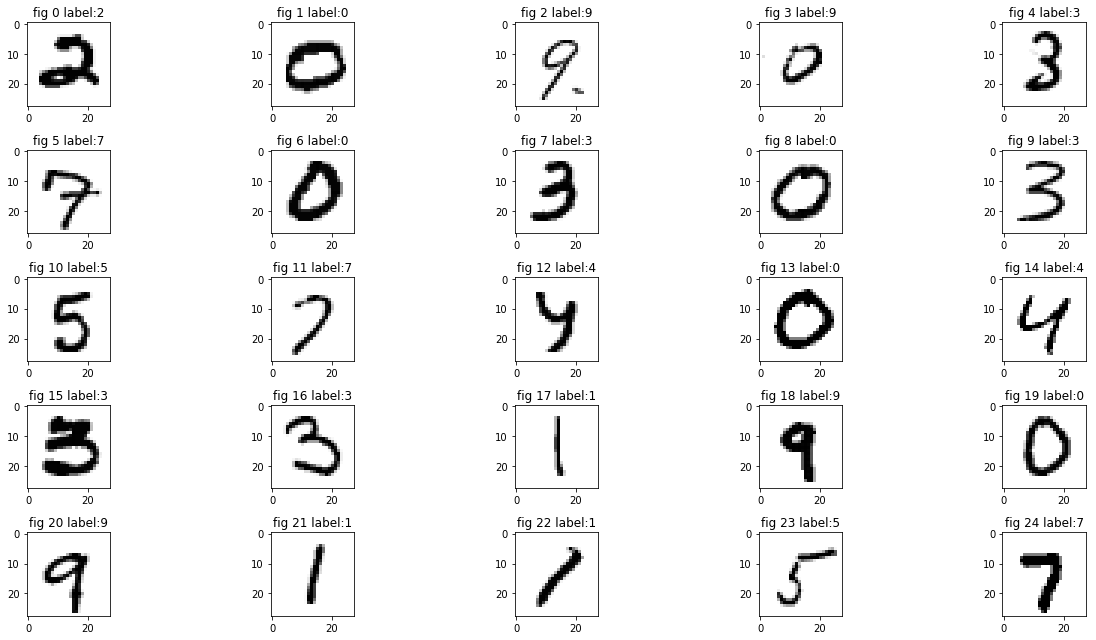

In [24]:
# show some fig
# 可视化25个测试数据的预测效果
plt.figure(figsize=(18,9))
for i in range(25):
    ax = plt.subplot2grid((5,5),(i / 5, i % 5))
    fig_data = test_fig_datas.iloc[i]
    ax.imshow(transformDataFrameFromSeries(fig_data), cmap=plt.cm.gray_r)
    plt.title('fig %s label:%s' % (i, test_label_datas[i]))
plt.tight_layout()
plt.show()

准确率挺厉害的，不过有一个0预测成9了。

In [23]:
submission = pd.DataFrame({
			"ImageId": range(1, test_data.shape[0]+1),
			"label": test_label_datas})
submission.to_csv("random_forest.csv", index=False)

什么参数都没调，数据也没做处理，分数已经达到0.96600。

再试试K近邻模型

In [24]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier(n_neighbors = 10)

knc.fit(train_x, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [25]:
test_label_datas = knc.predict(test_data)

In [26]:
# show some fig
plt.figure(figsize=(18,9))
for i in range(25):
    ax = plt.subplot2grid((5,5),(i / 5, i % 5))
    fig_data = test_fig_datas.iloc[i]
    ax.imshow(transformDataFrameFromSeries(fig_data), cmap=plt.cm.gray_r)
    plt.title('fig %s label:%s' % (i, test_label_datas[i]))
plt.tight_layout()
plt.show()

和随机森林在同一个数据错了，这个0预测成9了……

In [27]:
submission = pd.DataFrame({
			"ImageId": range(1, test_data.shape[0]+1),
			"label": test_label_datas})
submission.to_csv("KNN.csv", index=False)

在kaggle上拿到0.96557分。

### 优化尝试

从数据清洗上看，首先一份向量由784个像素点组成，每个像素点取值范围是0-255，这个样本空间就很大了，而其实每个像素点应该只有两个有效状态，是不是可以尝试对数据进行进一步降维处理。这个预处理需要确定一个阈值来判定像素点是否有效像素（非黑即白），可以按经验固定一个，也可以由每份向量的平均值来确定。


还有是不是可以对图形作“居中”处理，使得距离计算和像素点作为特征更准确。这个貌似需要识别出“有效像素”然后得到“有效图形区域”再平移到画布中点实现居中。

In [48]:
# 计算二维数据frame的中点
def calMeanPointSeries(dataSeries):
    acc_index_x = 0
    acc_index_y = 0
    acc_count = 0
    size = math.sqrt(dataSeries.size)
    for i in range(dataSeries.size):
        if(dataSeries[i] != 0.0):
            # accumulate index
            acc_index_x += (i / size)
            acc_index_y += (i % size)
            acc_count += 1
    return pd.Series([acc_index_x / acc_count, acc_index_y / acc_count])

In [20]:
meanIndexFrame = fig_datas.apply(calMeanPointSeries, axis=1)

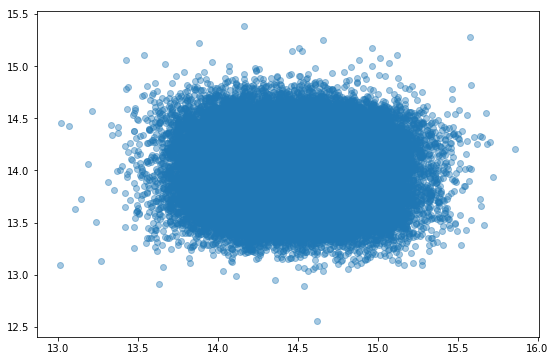

In [22]:
plt.figure(figsize=(9, 6))
plt.scatter(meanIndexFrame[0], meanIndexFrame[1], alpha=0.4, marker='o')
plt.show()

看起来有效点的空间分布上没啥大问题，基本集中在[13.5, 13]-[15.5, 15]之间。再看看有效像素值的分布情况。

In [51]:
# 计算有效像素点的均值和方差
def calPixelDistribution(dataSeries):
    dataSeries = dataSeries[dataSeries != 0.0]
    return pd.Series([dataSeries.mean(), dataSeries.std()])

In [50]:
pixelDisFrame = fig_datas.apply(calPixelDistribution, axis=1)

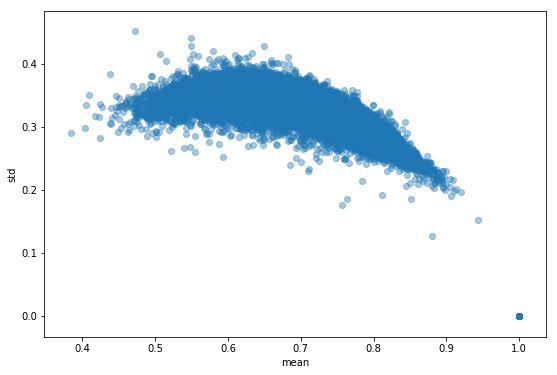

In [57]:
plt.figure(figsize=(9, 6))
plt.scatter(pixelDisFrame[0], pixelDisFrame[1],alpha=0.4, marker='o')
plt.xlabel('mean')
plt.ylabel('std')
plt.show()

总而言之，数据感觉挺干净的，没看出有啥优化清理的空间了……

### tensorflow

《Hands_On_Machine_Learning_with_Scikit_Learn_and_TensorFlow》练习记录。

In [21]:
# 直接用kaggle的测试集
train_x_tf = train_x.values.astype(np.float32) / 255.0
train_y_tf = train_y.values.astype(np.int32)
test_x_tf = test_data.values.astype(np.float32) / 255.0
X_valid, X_train = train_x_tf[:4200], train_x_tf[4200:]
y_valid, y_train = train_y_tf[:4200], train_y_tf[4200:]

**Chapter 10 – Introduction to Artificial Neural Networks**

#### Exercise 9.

_Train a deep MLP on the MNIST dataset and see if you can get over 98% precision. Just like in the last exercise of chapter 9, try adding all the bells and whistles (i.e., save checkpoints, restore the last checkpoint in case of an interruption, add summaries, plot learning curves using TensorBoard, and so on)._

下面是模型定义阶段

In [50]:
import tensorflow as tf

n_inputs = 28*28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [51]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [52]:
reset_graph()
# 训练数据占位符节点
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [53]:
# 三层网络结构定义
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1",
                              activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2",
                              activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [54]:
# 损失函数，这里是计算`logits`和`labels`的交叉熵作为损失函数
# logits为输出层的输出，格式为[训练集大小，10]
# labels为训练集的label，格式为[训练集大小]
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    # TensorBoard供数
    loss_summary = tf.summary.scalar('log_loss', loss)

In [55]:
# 梯度下降训练
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [56]:
# 评估模型效果
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    # TensorBoard供数
    accuracy_summary = tf.summary.scalar('accuracy', accuracy)

准备启动训练

In [67]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [66]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [75]:
# 记录训练日志，供TensorBoard展示用
from datetime import datetime

now = datetime.now().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [76]:
n_epochs = 150
n_batches = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, n_batches):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid, loss_valid, accuracy_summary_str, loss_summary_str = sess.run([accuracy, loss, accuracy_summary, loss_summary], feed_dict={X: X_valid, y: y_valid})
        #print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid, "Loss", loss_valid)
        file_writer.add_summary(accuracy_summary_str, epoch)
        file_writer.add_summary(loss_summary_str, epoch)

    save_path = saver.save(sess, "./DNN_plainTF/DNN_plainTF.ckpt")

file_writer.close()

使用训练模型预测测试数据

In [77]:
with tf.Session() as sess:
    saver.restore(sess, "./DNN_plainTF/DNN_plainTF.ckpt") # or better, use save_path
    Z = logits.eval(feed_dict={X: test_x_tf})
    y_pred = np.argmax(Z, axis=1)

INFO:tensorflow:Restoring parameters from ./DNN_plainTF/DNN_plainTF.ckpt


In [78]:
y_pred.shape

(28000,)

In [80]:
submission = pd.DataFrame({
			"ImageId": range(1, test_data.shape[0]+1),
			"Label": y_pred})
submission.to_csv("./DNN_plainTF/DNN-plainTF.csv", index=False)